# Hubbard 12 and FIL 24: ClassiFIM and other methods

## Init

In [2]:
import classifim
import classifim.bench
import classifim.bench.fidelity
import classifim.bench.metric
import classifim.bench.peaks
import classifim.bench.plot_tools
import classifim.bits
import classifim.datasets
import classifim.huang_pca
import classifim.pipeline
import classifim.twelve_sites_bc
import classifim.twelve_sites_pipeline
import classifim.twelve_sites_w
import classifim.utils
import concurrent.futures
import datasets
import datetime
import gc
import importlib
import itertools
import matplotlib
import matplotlib.pyplot as plt
import my.utils as myu
import numpy as np
import os.path
import pandas as pd
import re
import scipy.signal
import sklearn.cluster
import sklearn.decomposition
import sys
import time
import torch

DATA_DIR0 = classifim.utils.find_data_dir()
assert os.path.isdir(DATA_DIR0)
SM_NAMES = ["hubbard_12", "fil_24"]
SM_NAMES_PRINT = {"hubbard_12": "Hubbard12", "fil_24": "FIL24"}
DATA_DIRS = {
    sm_name: os.path.join(DATA_DIR0, sm_name.lower())
    for sm_name in SM_NAMES}
PARAMETER_GRID = [(0, 63/64, 64)] * 2
PARAMETER_GRID_EXPANDED = [np.linspace(*g) for g in PARAMETER_GRID]

config_device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Cuda is" + ("" if torch.cuda.is_available() else " NOT") + f" available; setting config_device = '{config_device}'.")

Cuda is NOT available; setting config_device = 'cpu'.


## Example: load the data

In [5]:
d_train_ds = datasets.load_dataset(
    'fiktor/FIM-Estimation',
    f'{SM_NAMES[1]}.seed42', split='train')
d_train = classifim.datasets.dataset_huggingface_to_dict(d_train_ds)

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

In [8]:
d_train

{'seed': 42,
 'lambdas': array([[0.      , 0.      ],
        [0.      , 0.      ],
        [0.      , 0.      ],
        ...,
        [0.984375, 0.984375],
        [0.984375, 0.984375],
        [0.984375, 0.984375]], dtype=float32),
 'samples': array([13172182, 12140307, 16209040, ...,  5595135,  5595135,  5595135],
       dtype=int32)}

## ClassiFIM training

### Pipeline

Pipeline used for both "FIL24" and "Hubbard12"

In [ ]:
for dataset_name in ("FIL24", "Hubbard12"):
    data_dir = os.path.join(DATA_DIR0, dataset_name.lower())
    datasets_dir = os.path.join(data_dir, "classifim_datasets")
    models_dir = classifim.utils.maybe_create_subdir(data_dir, "models")
    chifc_dir = classifim.utils.maybe_create_subdir(data_dir, "chifc")
    for seed in range(42, 52):
        print(f"Training a model for {dataset_name} {seed=}")
        config = {
            "dataset_filename": os.path.join(datasets_dir, f"dataset_{seed}.npz"),
            "model_filename": os.path.join(models_dir, f"9_reshuffle_{seed}.pth"),
            "chifc_filename": os.path.join(chifc_dir, f"9_reshuffle_{seed}.npz"),
            "test_dump_filename": os.path.join(datasets_dir, f"test_dump_{seed}.npz"),
            "num_epochs": 319,
            "device": config_device}
        pipeline = classifim.twelve_sites_pipeline.Pipeline(config)
        pipeline.load_data()
        pipeline.init_model()
        pipeline.train()
        pipeline.save_model()
        pipeline.load_model()
        pipeline.test()
        pipeline.eval_chifc()
        pipeline.save_chifc()
        dump = pipeline.record_test_data(use_bench_format=True)
        dump["seed"] = seed
        file_name = config["test_dump_filename"]
        np.savez_compressed(file_name, **dump)
        print(f"Dumped test data to '{file_name}'.")
        print("")

### Single run

In [218]:
t0 = time.time()
dataset_name = "Hubbard12"
data_dir = os.path.join(DATA_DIR0, dataset_name.lower())
datasets_dir = os.path.join(data_dir, "classifim_datasets")
models_dir = classifim.utils.maybe_create_subdir(data_dir, "models")
chifc_dir = classifim.utils.maybe_create_subdir(data_dir, "chifc")
seed = 42
print(f"Training a model for {dataset_name} {seed=}")
config = {
    "dataset_filename": os.path.join(datasets_dir, f"dataset_{seed}.npz"),
    "model_filename": os.path.join(models_dir, f"9_reshuffle_{seed}.pth"),
    "chifc_filename": os.path.join(chifc_dir, f"9_reshuffle_{seed}.npz"),
    "test_dump_filename": os.path.join(datasets_dir, f"test_dump_{seed}.npz"),
    "num_epochs": 319,
    "device": config_device}
t1 = time.time()
pipeline = classifim.twelve_sites_pipeline.Pipeline(config)
pipeline.load_data()
pipeline.init_model()
pipeline.train()
pipeline.save_model()
pipeline.cleanup_after_training()
pipeline.load_model()
pipeline.test()
pipeline.eval_chifc()
pipeline.save_chifc()
t2 = time.time()
dump = pipeline.record_test_data(use_bench_format=True)
dump["seed"] = seed
file_name = config["test_dump_filename"]
np.savez_compressed(file_name, **dump)
print(f"Dumped test data to '{file_name}'.")
t3 = time.time()
print(f"Timings: init={t1-t0:.3f}s, run={t2-t1}s, dump={t3-t2}s")

Training a model for Hubbard12 seed=42
num_epochs=319: 

NameError: name 'data_torch' is not defined

## Other methods training

### Binary phase classification

In [32]:
for seed in [44]:
    t0 = time.time()
    dataset_name = "FIL24"
    data_dir = os.path.join(DATA_DIR0, dataset_name.lower())
    datasets_dir = os.path.join(data_dir, "classifim_datasets")
    models_dir = classifim.utils.maybe_create_subdir(data_dir, "models")
    chifc_dir = classifim.utils.maybe_create_subdir(data_dir, "chifc")
    sweep_lambda_index = 0
    print(f"Training a model for {dataset_name} {seed=} {sweep_lambda_index=}")
    config = {
        "n_sites": 12,
        "suffix": str(seed),
        "dataset_filename": os.path.join(datasets_dir, f"dataset_{seed}.npz"),
        "model_filename": os.path.join(models_dir, f"bc_{seed}_{sweep_lambda_index}.pth"),
        "num_epochs": 319 * 2,
        "sweep_lambda_index": sweep_lambda_index,
        "max_lr": 5e-3,
        "hold_out_test": False,
        "scalar_keys": set(["seed"]),
        "device": config_device}
    t1 = time.time()
    pipeline = classifim.twelve_sites_bc.BCPipeline(config)
    pipeline.init_model()
    has_model = False
    try:
        pipeline.load_model()
        has_model = True
    except FileNotFoundError:
        print(f"No model in {config['model_filename']}. Will train a new one.")
    if not has_model:
        pipeline.init_model()
        pipeline.train()
        has_model = True
        pipeline.save_model()
    pipeline.cleanup_after_training()

Training a model for FIL24 seed=44 sweep_lambda_index=0
No model in /run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/models/bc_44_0.pth. Will train a new one.
2023-11-07 12:25:23.433366: Training started
num_epochs=638: 1:1.02 2:0.6739 3:0.5659 4:0.5157 5:0.4683 6:0.4166 7:0.3331 8:0.2564 9:0.172 10:0.1068 11:0.06393 12:0.03866 13:0.02534 14:0.018 15:0.01342 16:0.01114 17:0.008968 18:0.00871 19:0.007103 20:0.009105 21:0.006036 22:0.008342 23:0.006769 24:0.009585 25:0.01956 26:0.03473 27:0.04862 28:0.02166 29:0.01013 30:0.01774 31:0.01102 32:0.0311 33:0.007153 34:0.01028 35:0.005718 36:0.007929 37:0.005386 38:0.01018 39:0.006398 40:0.01461 41:0.005861 42:0.01318 43:0.005277 44:0.009345 45:0.005117 46:0.009819 47:0.005508 48:0.00912 49:0.005676 50:0.008342 51:0.007756 52:0.006492 53:0.005622 54:0.005999 55:0.006332 56:0.008332 57:0.2722 58:1.423 59:0.418 60:0.3108 61:0.04348 62:0.1145 63:0.02195 64:0.008959 65:0.009365 66:0.005564 67:0.005987 68:0.004579 69:0.004822

In [48]:
bc_results = []
for seed in range(42, 52):
    t0 = time.time()
    dataset_name = "FIL24"
    data_dir = os.path.join(DATA_DIR0, dataset_name.lower())
    datasets_dir = os.path.join(data_dir, "classifim_datasets")
    models_dir = classifim.utils.maybe_create_subdir(data_dir, "models")
    chifc_dir = classifim.utils.maybe_create_subdir(data_dir, "chifc")
    sweep_lambda_index = 0
    print(f"Training a model for {dataset_name} {seed=} {sweep_lambda_index=}")
    config = {
        "n_sites": 12,
        "suffix": str(seed),
        "dataset_filename": os.path.join(datasets_dir, f"dataset_{seed}.npz"),
        "model_filename": os.path.join(models_dir, f"bc_{seed}_{sweep_lambda_index}.pth"),
        "num_epochs": 319 * 2,
        "sweep_lambda_index": sweep_lambda_index,
        "max_lr": 5e-3,
        "hold_out_test": False,
        "scalar_keys": set(["seed"]),
        "device": config_device}
    t1 = time.time()
    pipeline = classifim.twelve_sites_bc.BCPipeline(config)
    pipeline.init_model()
    has_model = False
    try:
        pipeline.load_model()
        has_model = True
    except FileNotFoundError:
        print(f"No model in {config['model_filename']}. Will train a new one.")
    if not has_model:
        pipeline.init_model()
        pipeline.train()
        has_model = True
        pipeline.save_model()
    pipeline.cleanup_after_training()
    t2 = time.time()
    print(f"Timings: init={t1-t0:.3f}s, run={t2-t1:.3f}s")
    
    if "chifcs" not in globals() or chifcs["data_dir"] != data_dir:
        chifcs = load_chifc(data_dir=data_dir)
    
    gs_mg = extract_gs_meshgrid(chifcs["gs_chifc"], sweep_lambda_index)
    
    sweep_lambda_index = pipeline.dataset_train["sweep_lambda_index"]
    fixed_lambda_index = 1 - sweep_lambda_index
    lambda_fixed = pipeline.dataset_train["lambdas"][:, fixed_lambda_index]
    lambda_sweep = pipeline.dataset_train["lambdas"][:, sweep_lambda_index]
    pred_label_logit = pipeline.apply_model((
        pipeline.dataset_train["scaled_lambdas"][:, [fixed_lambda_index]].astype(np.float32),
        pipeline.dataset_train["unpacked_zs"].swapaxes(1, 2).astype(np.float32)))

    df = pd.DataFrame({
        "lambda_fixed": lambda_fixed,
        "lambda_sweep": lambda_sweep,
        "pred_label": 1 / (1 + np.exp(-pred_label_logit))})
    grouped_df = df.groupby(['lambda_fixed', 'lambda_sweep']).agg(
        cnt=('lambda_sweep', 'size'),               # Count the size of each group
        label_sum=('pred_label', 'sum'),            # Sum of pred_label for each group
        label_mean=('pred_label', 'mean')           # Mean of pred_label for each group
    ).reset_index()

    grouped_meshgrid = classifim.bench.plot_tools.df_to_meshgrid(grouped_df, "lambda_fixed", "lambda_sweep")

    ml_mg = extract_ml_meshgrid(chifcs["ml_fim_mgrids"][seed], sweep_lambda_index)
    sweep_lambda_max_gs = gs_mg['lambda_sweep'][np.argmax(gs_mg["fim"], axis=1)]
    sweep_lambda_max_ml = ml_mg['lambda_sweep'][np.argmax(ml_mg["fim"], axis=1)]
    compute_lambda_sweep_root(grouped_meshgrid)

    gs_vals = sweep_lambda_max_gs[28:]
    ml_vals = sweep_lambda_max_ml[28:]
    bc_vals = grouped_meshgrid["lambda_sweep_root"][28:]
    rmse_ml = np.mean((ml_vals - gs_vals)**2)**0.5
    rmse_bc = np.mean((bc_vals - gs_vals)**2)**0.5
    print(f"seed={seed} RMSEs: ML: {rmse_ml:.4f}, BC: {rmse_bc:.4f}")
    bc_results.append({
        "seed": seed,
        "rmse_ml": rmse_ml,
        "rmse_bc": rmse_bc,
        "t_init": t1-t0,
        "t_run": t2-t1
    })

Training a model for FIL24 seed=42 sweep_lambda_index=0
Loaded model from '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/models/bc_42_0.pth'
Timings: init=0.000s, run=0.251s
seed=42 RMSEs: ML: 0.0171, BC: 0.0372
Training a model for FIL24 seed=43 sweep_lambda_index=0
Loaded model from '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/models/bc_43_0.pth'
Timings: init=0.000s, run=0.177s
seed=43 RMSEs: ML: 0.0119, BC: 0.4979
Training a model for FIL24 seed=44 sweep_lambda_index=0
Loaded model from '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/models/bc_44_0.pth'
Timings: init=0.000s, run=0.177s
seed=44 RMSEs: ML: 0.0154, BC: 0.0343
Training a model for FIL24 seed=45 sweep_lambda_index=0
No model in /run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil24/models/bc_45_0.pth. Will train a new one.
2023-11-07 12:45:04.775880: Training started
num_epochs=638: 1:0.8191 2:0.6343 3:0.5639 4:0.5015 5:0.4504 6:

### Results

In [49]:
bc_df = pd.DataFrame({
    key: [v[key] for v in bc_results]
    for key in bc_results[0].keys()})
bc_df

,seed,rmse_ml,rmse_bc,t_init,t_run
0,42,0.017077,0.037246,0.000243,0.250844
1,43,0.011934,0.497908,0.000355,0.176786
2,44,0.015406,0.034339,0.000360,0.177376
3,45,0.016675,0.035172,0.000370,289.851501
4,46,0.016263,0.032211,0.000219,289.923620
5,47,0.016675,0.034752,0.000361,289.488018
6,48,0.015841,0.036951,0.000221,291.873223
7,49,0.011351,0.034596,0.000364,289.809230
8,50,0.016675,0.035391,0.000362,289.302700
9,51,0.017853,0.034810,0.000362,289.597054


In [52]:
bc_df["dir"] = 0
bc_df["CF"] = bc_df["rmse_ml"]
bc_df["BC"] = bc_df["rmse_bc"]
value_columns = ["CF", "BC"]
grouped_df = bc_df[bc_df["seed"] != 43].groupby('dir').agg(
    **{k: v
        for key in value_columns
        for k, v in [(key, (key, 'mean')), (key + "_std", (key, 'std'))]
    }).reset_index()

# summary_df = {key: grouped_df[key].to_numpy() for key in ["dir", "#", "#acc", "#single"]}
# summary_df.update({
#     key: [f"{a:.5f}±{b:.5f}"
#           for a, b in zip(grouped_df[key], grouped_df[key + "_std"])]
#     for key in value_columns})
grouped_df

,dir,CF,CF_std,BC,BC_std
0,0,0.01598,0.001871,0.035052,0.001478


In [43]:
grouped_meshgrid["label_mean"][0, 3] == grouped_meshgrid["label_mean"][1, 3]

True

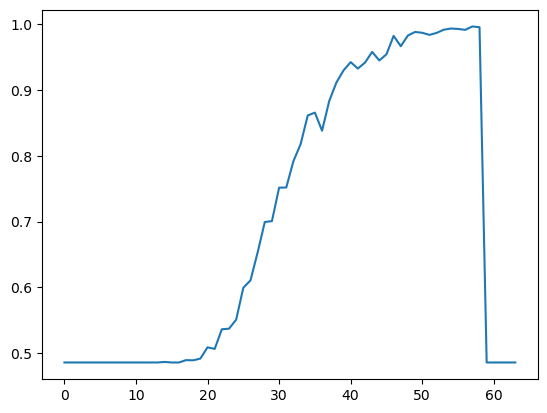

In [42]:
plt.plot(grouped_meshgrid["label_mean"][:, 3])

Saved to /home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/bitstring-chifc/supplementary_materials/code/examples/FIL24_bc_phase_sweep_0.png


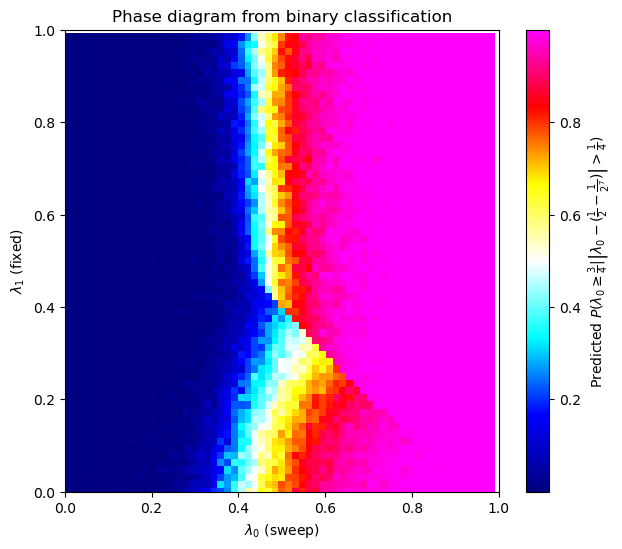

In [241]:
fig, ax = plt.subplots(figsize=(7, 6))
do_transpose = (sweep_lambda_index == 0)

# Assuming data["x"], data["y"], and data["z"] are already numpy arrays of the same shape
x, y, z = grouped_meshgrid["lambda_fixed"], grouped_meshgrid["lambda_sweep"], grouped_meshgrid["label_mean"]
if do_transpose:
    x, y, z = y, x, z.T

# Plotting the data
cp = ax.pcolormesh(x, y, z, cmap=classifim.bench.plot_tools.spiral_background2_cmap, shading='auto')

# Add a color bar
cbar = plt.colorbar(cp, ax=ax)
lambda_fixed_latex = "\\lambda_{" + f"{fixed_lambda_index:d}" + "}"
lambda_sweep_latex = "\\lambda_{" + f"{sweep_lambda_index:d}" + "}"
cbar.set_label(
    "Predicted $P(" + lambda_sweep_latex + " \\geq \\frac{3}{4} | "
    + "\\left|" + lambda_sweep_latex + " - (\\frac{1}{2} - \\frac{1}{2^7})\\right| > \\frac{1}{4})$")

# Set plot labels and title as needed
x_label = f"${lambda_fixed_latex}$ (fixed)"
y_label = "$\\lambda_{" + f"{sweep_lambda_index:d}" + "}$ (sweep)"
if do_transpose:
    x_label, y_label = y_label, x_label
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title('Phase diagram from binary classification')

# Other possible customizations
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Saving the figure if needed
filename = f"{dataset_name}_bc_phase_sweep_{sweep_lambda_index}.png"
plt.savefig(filename, dpi=300)
print(f"Saved to {os.path.realpath(filename)}")

# Show the plot
plt.show()

Figure saved to /home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/bitstring-chifc/supplementary_materials/code/examples/bc0_lambda0_31.png


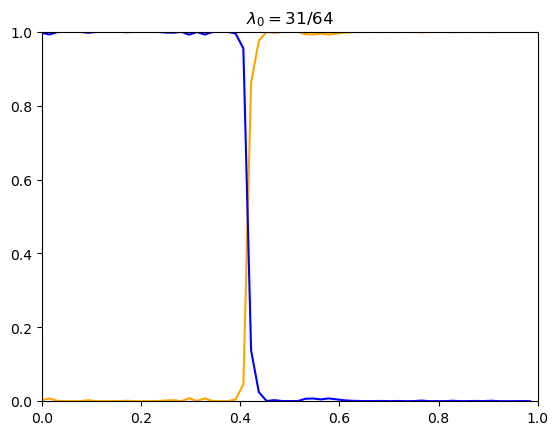

In [145]:
fig, ax = plt.subplots()
ax.plot(grouped_df["lambda_x"], grouped_df["label_mean"], 'orange')
ax.plot(grouped_df["lambda_x"], 1 - grouped_df["label_mean"], 'blue')
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_title("$\lambda_{" + f"{fixed_lambda_index:d}" + "} = " + f"{int(fixed_lambda_value * 64):d}/64$")
filename = f"bc0_lambda{fixed_lambda_index:d}_{int(fixed_lambda_value * 64):d}.png"
fig.savefig(filename, bbox_inches='tight')
print(f"Figure saved to {os.path.realpath(filename)}")

### Plot peak locations

In [148]:
y = grouped_df["label_mean"].to_numpy() - 0.5

In [47]:
def linear_root(y0, y1):
    """Returns the root of the function x \to y0 + (y1 - y0) * x."""
    assert y0 * y1 <= 0
    return y0 / (y0 - y1)

def find_root(y):
    assert y[0] < 0 and y[-1] > 0, f"{y[0]=}, {y[-1]=}"
    sign_change_idx = np.nonzero(np.diff(np.sign(y)))[0]
    assert len(sign_change_idx) > 0
    def root_at(i):
        return i + linear_root(y[i], y[i+1])
    x0 = root_at(sign_change_idx[0])
    x1 = root_at(sign_change_idx[-1])
    return (x1 + x0) / 2

def compute_lambda_sweep_root(grouped_meshgrid):
    root = []
    for i in range(len(grouped_meshgrid["lambda_fixed"])):
        vi = grouped_meshgrid["label_mean"][:, i] - 0.5
        eps = 1e-5
        if vi[-1] <= 0:
            vi = vi + np.linspace(0, eps - vi[-1], len(vi))
        if vi[0] >= 0:
            vi = vi - np.linspace(eps + vi[0], 0, len(vi))
        root.append(find_root(vi))
    root = np.array(root)
    int_root = root.astype(int)
    frac_root = root - int_root
    lambda0 = grouped_meshgrid["lambda_sweep"][int_root]
    lambda1 = grouped_meshgrid["lambda_sweep"][int_root + 1]
    grouped_meshgrid["lambda_sweep_root"] = lambda0 + frac_root * (lambda1 - lambda0)

In [51]:
ml_fim_mgrid = ml_fim_mgrids[41]
sweep_lambda_name = f'lambda{sweep_lambda_index:d}'
fixed_lambda_name = f'lambda{fixed_lambda_index:d}'
chifc_name = f'chifc_{sweep_lambda_index:d}{sweep_lambda_index:d}'
sweep_lambda_max_ml = ml_fim_mgrid[sweep_lambda_name][np.argmax(ml_fim_mgrid[chifc_name], axis=1-sweep_lambda_index)]

gs_df = gs_chifc[gs_chifc["dir"] == str(sweep_lambda_index)]
gs_mg = classifim.bench.plot_tools.df_to_meshgrid(gs_df, "lambda0", "lambda1")
sweep_lambda_max_gs = gs_mg[sweep_lambda_name][np.argmax(gs_mg["chi_fc"], axis=1-sweep_lambda_index)]

Saved fig to /home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/bitstring-chifc/supplementary_materials/code/examples/lambda_sweep_root.png


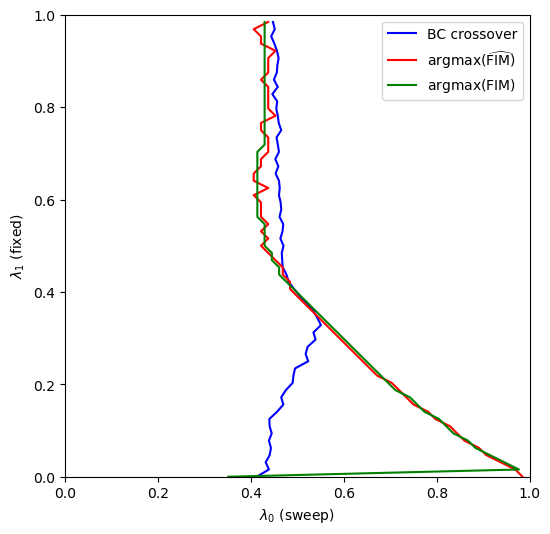

In [339]:
def plot_t(ax, do_transpose, x, y, **kwargs):
    if do_transpose:
        x, y = y, x
    ax.plot(x, y, **kwargs)
def set_xy_labels_t(ax, do_transpose, x_label, y_label):
    if do_transpose:
        x_label, y_label = y_label, x_label
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
fig, ax = plt.subplots(figsize=(6, 6))
plot_t(ax, do_transpose, grouped_meshgrid["lambda_fixed"], grouped_meshgrid["lambda_sweep_root"], color='blue',
       label='BC crossover')
plot_t(ax, do_transpose, ml_fim_mgrid[fixed_lambda_name], sweep_lambda_max_ml, color='red',
       label=r'$\mathrm{argmax}(\widehat{\mathrm{FIM}})$')
plot_t(ax, do_transpose, gs_mg[fixed_lambda_name], sweep_lambda_max_gs, color='green',
       label=r'$\mathrm{argmax}(\mathrm{FIM})$')
set_xy_labels_t(ax, do_transpose, f"${lambda_fixed_latex}$ (fixed)", "$\\lambda_{" + f"{sweep_lambda_index:d}" + "}$ (sweep)")
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.legend()
filename = "lambda_sweep_root.png"
fig.savefig(filename)
print(f"Saved fig to {os.path.realpath(filename)}")

RMSE of ClassiFIM and BC in the top half of the graph (there are two peaks in the bottom half):

FIM, ClassiFIM, and BC on the same 2D graph:

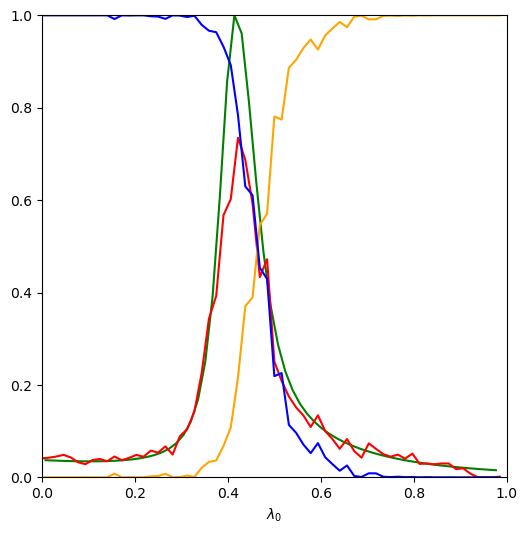

In [329]:
fig, ax = plt.subplots(figsize=(6,6))
gs_df = gs_chifc[(gs_chifc["lambda1"] == 38/64) & (gs_chifc["dir"] == '0')]
ax.plot(gs_df["lambda0"], gs_df["chi_fc"] / np.max(gs_df["chi_fc"]), color='green')
ml_df = ml_fims[41]
ml_df = ml_df[ml_df["lambda1"] == 38/64]
ax.plot(ml_df["lambda0"], ml_df["chifc_00"] / np.max(gs_df["chi_fc"]), color='red')
g_df = grouped_df[grouped_df["lambda_fixed"] == 38/64]
ax.plot(g_df["lambda_sweep"], g_df["label_mean"], 'orange')
ax.plot(g_df["lambda_sweep"], 1 - g_df["label_mean"], 'blue')
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xlabel(r"$\lambda_0$")
fig.savefig("bc_comparison_lambda1_38_64.png")

### Free GPU memory

In [407]:
def del_models():
    """Delete the previous models."""
    models_var_names = {'model', 'model_loge', 'model_linear'}
    for key in models_var_names:
        if key in globals():
            del globals()[key]
            
def del_jupyter_output():
    """Delete all global variables matching r'^_[0-9]*$' and keys of 'Out'.

    These names are typically used for output cells in jupyter-lab.
    This function followed by gc.collect() helps to free up memory
    or other resources occupied by unused vars.
    
    Usually, this duplicates the work of '%reset out', hence no
    additional variables are expected to be freed this way.
    If for some reason the magic '%reset out' is not working,
    this function could be used as an alternative.
    """
    globals_keys = list(globals().keys())
    for key in globals_keys:
        if re.match(r'^_[0-9]*$', key):
            del globals()[key]
    if 'Out' in globals_keys:
        out_keys = list(globals()['Out'].keys())
        for key in out_keys:
            del globals()['Out'][key]

def free_gpu_memory():
    del_models()
    del_jupyter_output()
    gc.collect()

free_gpu_memory()

In [408]:
print(torch.cuda.memory_allocated(0) / 1024**3)

0.08510112762451172


### Van Nieuwenburg's W

In [7]:
importlib.reload(classifim.io)
importlib.reload(classifim.pipeline)
importlib.reload(classifim.twelve_sites_pipeline)
importlib.reload(classifim.twelve_sites_bc)
importlib.reload(classifim.twelve_sites_w)
importlib.reload(classifim.w)

def gen_wconfig(**kwargs):
    config = {
        "n_sites": 12,
        "num_epochs": 6,
        "one_cycle_lr.num_epochs": 7,
        "batch_size": 2**8,
        "max_lr": 5e-3,
        "hold_out_test": True,
        "test_fraction": 0.5,
        "one_cycle_lr.pct_start": 0.0,
        "scalar_keys": set(["seed"]),
        "model_name": "w",
        "model_init_kwargs": {
            "cnn_version": 3,
            "zs_pool_version": 2,
            "fc_width": 56},
        "device": config_device}    
    config.update(kwargs)
    classifim.w.config_set_default_filenames(
        config,
        models_dir=os.path.join(DATA_DIR0, config["sm_name"], "models"))
    return config

In [8]:
for sm_name, seed, sweep_lambda_index in itertools.product(SM_NAMES, range(42, 52), range(2)):
    classifim.w.run_pipeline(
        sm_name=sm_name,
        gen_config_f=gen_wconfig,
        gen_pipeline_f=classifim.twelve_sites_w.WPipeline,
        seed=seed, sweep_lambda_index=sweep_lambda_index, skip_existing=False)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

2024-05-16 19:47:17.427766: w_42
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_42_0.w.npz
2024-05-16 19:47:17.637416: Train i=0
2024-05-16 19:47:17.789732: Training started
num_epochs=6: 1:0.7514 2:0.5463 3:0.5238 4:0.4925 5:0.4772 6:0.4697 
2024-05-16 19:47:22.316091: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_42_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_42_0_0.pth'
2024-05-16 19:47:22.323857: Eval W
loss: 0.463131, accuracy: 75.98%, num_points: 4004, num_thresholds: 63.
2024-05-16 19:47:22.587997: Train i=1
2024-05-16 19:47:22.591887: Training started
num_epochs=6: 1:0.5806 2:0.5 3:0.4416 4:0.4069 5:0.3886 6:0.3809 
2024-05-16 19:47:27.063580: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_42_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschif

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

2024-05-16 19:57:16.315625: w_43
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_43_0.w.npz
2024-05-16 19:57:16.488145: Train i=0
2024-05-16 19:57:16.492167: Training started
num_epochs=6: 1:0.7729 2:0.567 3:0.5325 4:0.5071 5:0.4946 6:0.4883 
2024-05-16 19:57:20.647763: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_43_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_43_0_0.pth'
2024-05-16 19:57:20.655305: Eval W
loss: 0.490150, accuracy: 74.49%, num_points: 4119, num_thresholds: 63.
2024-05-16 19:57:20.908730: Train i=1
2024-05-16 19:57:20.915093: Training started
num_epochs=6: 1:0.5973 2:0.5385 3:0.4601 4:0.4325 5:0.409 6:0.3987 
2024-05-16 19:57:25.092905: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_43_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschi

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 20:06:59.749146: w_44
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_44_0.w.npz
2024-05-16 20:06:59.957911: Train i=0
2024-05-16 20:06:59.962214: Training started
num_epochs=6: 1:0.8042 2:0.5704 3:0.5381 4:0.5151 5:0.5014 6:0.4952 
2024-05-16 20:07:04.125392: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_44_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_44_0_0.pth'
2024-05-16 20:07:04.132620: Eval W
loss: 0.490269, accuracy: 74.54%, num_points: 4140, num_thresholds: 63.
2024-05-16 20:07:04.386542: Train i=1
2024-05-16 20:07:04.390520: Training started
num_epochs=6: 1:0.5678 2:0.5346 3:0.4587 4:0.4155 5:0.3926 6:0.3826 
2024-05-16 20:07:08.567130: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_44_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bsc

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 20:16:42.904147: w_45
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_45_0.w.npz
2024-05-16 20:16:43.111733: Train i=0
2024-05-16 20:16:43.116140: Training started
num_epochs=6: 1:0.7868 2:0.5323 3:0.5267 4:0.4952 5:0.4786 6:0.4704 
2024-05-16 20:16:47.350319: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_45_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_45_0_0.pth'
2024-05-16 20:16:47.357409: Eval W
loss: 0.466749, accuracy: 76.10%, num_points: 3993, num_thresholds: 63.
2024-05-16 20:16:47.601697: Train i=1
2024-05-16 20:16:47.605933: Training started
num_epochs=6: 1:0.5695 2:0.4989 3:0.4315 4:0.3953 5:0.3761 6:0.3678 
2024-05-16 20:16:51.912515: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_45_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bsc

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 20:26:25.745872: w_46
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_46_0.w.npz
2024-05-16 20:26:25.957288: Train i=0
2024-05-16 20:26:25.961664: Training started
num_epochs=6: 1:0.7714 2:0.5769 3:0.5311 4:0.5095 5:0.4956 6:0.4893 
2024-05-16 20:26:30.166800: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_46_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_46_0_0.pth'
2024-05-16 20:26:30.173986: Eval W
loss: 0.488578, accuracy: 74.64%, num_points: 4082, num_thresholds: 63.
2024-05-16 20:26:30.425032: Train i=1
2024-05-16 20:26:30.429037: Training started
num_epochs=6: 1:0.615 2:0.5131 3:0.4651 4:0.4329 5:0.4118 6:0.4007 
2024-05-16 20:26:34.754374: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_46_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bsch

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 20:36:08.266887: w_47
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_47_0.w.npz
2024-05-16 20:36:08.483948: Train i=0
2024-05-16 20:36:08.490480: Training started
num_epochs=6: 1:0.7792 2:0.5749 3:0.5371 4:0.5148 5:0.5016 6:0.4957 
2024-05-16 20:36:12.645477: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_47_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_47_0_0.pth'
2024-05-16 20:36:12.654240: Eval W
loss: 0.491996, accuracy: 74.86%, num_points: 4129, num_thresholds: 63.
2024-05-16 20:36:12.908695: Train i=1
2024-05-16 20:36:12.913212: Training started
num_epochs=6: 1:0.5774 2:0.4753 3:0.426 4:0.3993 5:0.3856 6:0.3798 
2024-05-16 20:36:17.088465: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_47_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bsch

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 20:45:50.725561: w_48
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_48_0.w.npz
2024-05-16 20:45:50.891339: Train i=0
2024-05-16 20:45:50.895320: Training started
num_epochs=6: 1:0.7694 2:0.5264 3:0.5185 4:0.4926 5:0.4785 6:0.472 
2024-05-16 20:45:55.119698: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_48_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_48_0_0.pth'
2024-05-16 20:45:55.127017: Eval W
loss: 0.473198, accuracy: 75.03%, num_points: 4071, num_thresholds: 63.
2024-05-16 20:45:55.377630: Train i=1
2024-05-16 20:45:55.381631: Training started
num_epochs=6: 1:0.5724 2:0.4932 3:0.4317 4:0.4002 5:0.3798 6:0.3721 
2024-05-16 20:45:59.610015: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_48_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bsch

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 20:55:36.662378: w_49
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_49_0.w.npz
2024-05-16 20:55:36.856928: Train i=0
2024-05-16 20:55:36.860999: Training started
num_epochs=6: 1:0.9175 2:0.5657 3:0.5345 4:0.5108 5:0.4982 6:0.493 
2024-05-16 20:55:41.205316: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_49_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_49_0_0.pth'
2024-05-16 20:55:41.212709: Eval W
loss: 0.496370, accuracy: 74.59%, num_points: 4012, num_thresholds: 63.
2024-05-16 20:55:41.459491: Train i=1
2024-05-16 20:55:41.463846: Training started
num_epochs=6: 1:0.573 2:0.5812 3:0.4533 4:0.4248 5:0.4005 6:0.3899 
2024-05-16 20:55:45.748012: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_49_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschi

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 21:05:19.831313: w_50
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_50_0.w.npz
2024-05-16 21:05:20.012929: Train i=0
2024-05-16 21:05:20.017020: Training started
num_epochs=6: 1:0.905 2:0.561 3:0.5393 4:0.5154 5:0.5049 6:0.4994 
2024-05-16 21:05:24.230898: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_50_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_50_0_0.pth'
2024-05-16 21:05:24.238120: Eval W
loss: 0.496722, accuracy: 74.77%, num_points: 4018, num_thresholds: 63.
2024-05-16 21:05:24.486106: Train i=1
2024-05-16 21:05:24.490156: Training started
num_epochs=6: 1:0.6092 2:0.6135 3:0.4995 4:0.4771 5:0.4524 6:0.4426 
2024-05-16 21:05:28.802360: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_50_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschi

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 21:15:02.994447: w_51
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_0.w.npz
2024-05-16 21:15:03.198902: Train i=0
2024-05-16 21:15:03.203420: Training started
num_epochs=6: 1:0.99 2:0.5422 3:0.5356 4:0.5104 5:0.4978 6:0.4914 
2024-05-16 21:15:07.512196: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_0_0.pth'
2024-05-16 21:15:07.519419: Eval W
loss: 0.492357, accuracy: 74.84%, num_points: 3946, num_thresholds: 63.
2024-05-16 21:15:07.762012: Train i=1
2024-05-16 21:15:07.766122: Training started
num_epochs=6: 1:0.5814 2:0.5133 3:0.4626 4:0.4226 5:0.4006 6:0.3909 
2024-05-16 21:15:12.114886: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschi

Using the latest cached version of the dataset since fiktor/FIM-Estimation couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'hubbard_12.seed51' at /home/victor/.cache/huggingface/datasets/fiktor___fim-estimation/hubbard_12.seed51/0.0.0/f7030ac62c78aff4aa676b554a28baff5b753831 (last modified on Thu May 16 21:15:01 2024).


2024-05-16 21:21:33.069911: w_51
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_1.w.npz
2024-05-16 21:21:33.220989: Train i=0
2024-05-16 21:21:33.231438: Training started
num_epochs=6: 1:0.7929 2:0.6318 3:0.5363 4:0.5125 5:0.5004 6:0.495 
2024-05-16 21:21:37.604001: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_1_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_1_0.pth'
2024-05-16 21:21:37.611164: Eval W
loss: 0.496877, accuracy: 74.40%, num_points: 3916, num_thresholds: 63.
2024-05-16 21:21:37.851221: Train i=1
2024-05-16 21:21:37.855517: Training started
num_epochs=6: 1:0.7448 2:0.6138 3:0.5278 4:0.5095 5:0.4978 6:0.4927 
2024-05-16 21:21:42.034541: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/models/w_51_1_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bsch

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 21:26:25.324748: w_42
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_42_0.w.npz
2024-05-16 21:26:25.502875: Train i=0
2024-05-16 21:26:25.507072: Training started
num_epochs=6: 1:0.8256 2:0.4673 3:0.3879 4:0.3433 5:0.3235 6:0.3165 
2024-05-16 21:26:29.737708: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_42_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_42_0_0.pth'
2024-05-16 21:26:29.744774: Eval W
loss: 0.314177, accuracy: 84.18%, num_points: 4004, num_thresholds: 63.
2024-05-16 21:26:29.991041: Train i=1
2024-05-16 21:26:29.995115: Training started
num_epochs=6: 1:0.54 2:0.3998 3:0.3455 4:0.3137 5:0.2898 6:0.2808 
2024-05-16 21:26:34.253707: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_42_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 21:36:07.829359: w_43
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_43_0.w.npz
2024-05-16 21:36:07.991198: Train i=0
2024-05-16 21:36:07.995273: Training started
num_epochs=6: 1:0.9105 2:0.4923 3:0.4167 4:0.349 5:0.3188 6:0.3082 
2024-05-16 21:36:12.147524: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_43_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_43_0_0.pth'
2024-05-16 21:36:12.154402: Eval W
loss: 0.307141, accuracy: 85.50%, num_points: 4119, num_thresholds: 63.
2024-05-16 21:36:12.407851: Train i=1
2024-05-16 21:36:12.412173: Training started
num_epochs=6: 1:0.5676 2:0.4668 3:0.3902 4:0.3474 5:0.3216 6:0.3112 
2024-05-16 21:36:16.590121: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_43_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 21:45:50.680440: w_44
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_44_0.w.npz
2024-05-16 21:45:50.876759: Train i=0
2024-05-16 21:45:50.880819: Training started
num_epochs=6: 1:0.9471 2:0.4943 3:0.4108 4:0.3471 5:0.3192 6:0.309 
2024-05-16 21:45:55.049184: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_44_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_44_0_0.pth'
2024-05-16 21:45:55.056116: Eval W
loss: 0.310192, accuracy: 84.59%, num_points: 4140, num_thresholds: 63.
2024-05-16 21:45:55.310301: Train i=1
2024-05-16 21:45:55.314289: Training started
num_epochs=6: 1:0.5337 2:0.484 3:0.3732 4:0.3301 5:0.3056 6:0.2957 
2024-05-16 21:45:59.492261: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_44_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 21:55:33.321150: w_45
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_45_0.w.npz
2024-05-16 21:55:33.518974: Train i=0
2024-05-16 21:55:33.523940: Training started
num_epochs=6: 1:0.9194 2:0.4578 3:0.3984 4:0.3529 5:0.3294 6:0.3214 
2024-05-16 21:55:37.758014: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_45_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_45_0_0.pth'
2024-05-16 21:55:37.765204: Eval W
loss: 0.318285, accuracy: 83.64%, num_points: 3993, num_thresholds: 63.
2024-05-16 21:55:38.010721: Train i=1
2024-05-16 21:55:38.014851: Training started
num_epochs=6: 1:0.5316 2:0.4278 3:0.3829 4:0.3397 5:0.3109 6:0.3002 
2024-05-16 21:55:42.321564: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_45_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurip

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 22:05:16.754813: w_46
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_46_0.w.npz
2024-05-16 22:05:16.950174: Train i=0
2024-05-16 22:05:16.954137: Training started
num_epochs=6: 1:0.8699 2:0.5013 3:0.4094 4:0.355 5:0.3247 6:0.3138 
2024-05-16 22:05:21.170436: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_46_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_46_0_0.pth'
2024-05-16 22:05:21.221488: Eval W
loss: 0.308910, accuracy: 83.97%, num_points: 4082, num_thresholds: 63.
2024-05-16 22:05:21.472419: Train i=1
2024-05-16 22:05:21.476445: Training started
num_epochs=6: 1:0.5935 2:0.4603 3:0.3756 4:0.3348 5:0.3145 6:0.3062 
2024-05-16 22:05:25.803767: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_46_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 22:14:59.642526: w_47
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_47_0.w.npz
2024-05-16 22:14:59.839640: Train i=0
2024-05-16 22:14:59.843776: Training started
num_epochs=6: 1:0.8707 2:0.4964 3:0.4117 4:0.3532 5:0.3222 6:0.3096 
2024-05-16 22:15:03.990106: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_47_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_47_0_0.pth'
2024-05-16 22:15:03.996952: Eval W
loss: 0.309783, accuracy: 84.85%, num_points: 4129, num_thresholds: 63.
2024-05-16 22:15:04.252715: Train i=1
2024-05-16 22:15:04.256875: Training started
num_epochs=6: 1:0.5335 2:0.3831 3:0.3283 4:0.3027 5:0.2851 6:0.2783 
2024-05-16 22:15:08.430069: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_47_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurip

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 22:24:41.481912: w_48
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_48_0.w.npz
2024-05-16 22:24:41.687822: Train i=0
2024-05-16 22:24:41.692273: Training started
num_epochs=6: 1:0.8485 2:0.4501 3:0.3905 4:0.3407 5:0.3167 6:0.3065 
2024-05-16 22:24:45.918878: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_48_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_48_0_0.pth'
2024-05-16 22:24:45.925810: Eval W
loss: 0.307474, accuracy: 84.58%, num_points: 4071, num_thresholds: 63.
2024-05-16 22:24:46.176904: Train i=1
2024-05-16 22:24:46.183364: Training started
num_epochs=6: 1:0.5299 2:0.4245 3:0.3673 4:0.3282 5:0.3042 6:0.2946 
2024-05-16 22:24:50.407039: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_48_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurip

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 22:34:24.206609: w_49
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_49_0.w.npz
2024-05-16 22:34:24.402206: Train i=0
2024-05-16 22:34:24.406205: Training started
num_epochs=6: 1:1.178 2:0.4858 3:0.4041 4:0.3324 5:0.3046 6:0.2949 
2024-05-16 22:34:28.731891: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_49_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_49_0_0.pth'
2024-05-16 22:34:28.738864: Eval W
loss: 0.302432, accuracy: 85.91%, num_points: 4012, num_thresholds: 63.
2024-05-16 22:34:28.985262: Train i=1
2024-05-16 22:34:28.989262: Training started
num_epochs=6: 1:0.5121 2:0.4969 3:0.3466 4:0.3112 5:0.2875 6:0.2795 
2024-05-16 22:34:33.274016: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_49_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 22:44:08.454095: w_50
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_50_0.w.npz
2024-05-16 22:44:08.626142: Train i=0
2024-05-16 22:44:08.630170: Training started
num_epochs=6: 1:1.074 2:0.4712 3:0.3975 4:0.3274 5:0.3037 6:0.2943 
2024-05-16 22:44:12.842877: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_50_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_50_0_0.pth'
2024-05-16 22:44:12.849797: Eval W
loss: 0.290078, accuracy: 86.12%, num_points: 4018, num_thresholds: 63.
2024-05-16 22:44:13.097053: Train i=1
2024-05-16 22:44:13.101021: Training started
num_epochs=6: 1:0.5302 2:0.5601 3:0.3663 4:0.339 5:0.3043 6:0.293 
2024-05-16 22:44:17.411351: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_50_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips20

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-16 22:54:04.214422: w_51
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_51_0.w.npz
2024-05-16 22:54:04.418496: Train i=0
2024-05-16 22:54:04.422861: Training started
num_epochs=6: 1:1.215 2:0.4845 3:0.4288 4:0.3557 5:0.3213 6:0.3074 
2024-05-16 22:54:08.738393: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_51_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_51_0_0.pth'
2024-05-16 22:54:08.747461: Eval W
loss: 0.306019, accuracy: 84.81%, num_points: 3946, num_thresholds: 63.
2024-05-16 22:54:08.990103: Train i=1
2024-05-16 22:54:08.994074: Training started
num_epochs=6: 1:0.5672 2:0.4153 3:0.368 4:0.3249 5:0.2944 6:0.2823 
2024-05-16 22:54:13.337844: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/models/w_51_0_1.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2

### ClassiFIM postprocessing

NameError: name 'ml_mg' is not defined

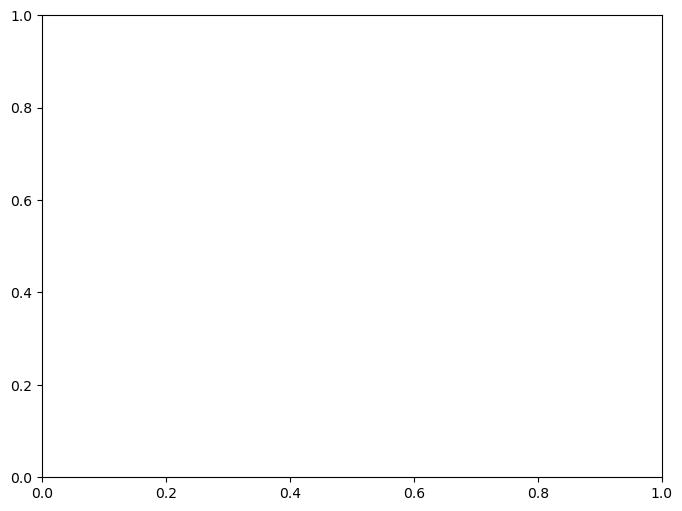

In [9]:
lambda_fixed_idx = 25
fig, ax1 = plt.subplots(nrows=1, figsize=(8, 6))
x = ml_mg["lambda_fixed"]
y = ml_mg["fim"][lambda_fixed_idx]
ax1.plot(x, y, color='red')

x1, y1 = smoothen_classifim_1d(x, ml_mg["fim"], axis=1)
y1 = y1[lambda_fixed_idx]
ax1.plot(x1, y1, color='green')

ax1.set_ylabel("scaled FIM")
ax1.set_xlabel(r"$\lambda_0$")
ax1.set_xlim(0 - 1/128, 1 - 1/128)
ax1.set_ylim(0, np.max(y))
fig.savefig("smooth_classifim.png")

#### Get and plot W

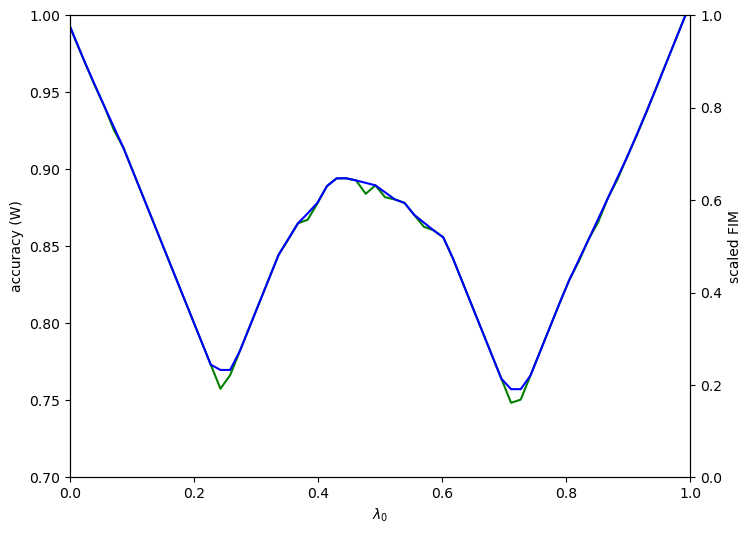

In [116]:
lambda_fixed_idx = 25

fig, ax1 = plt.subplots(nrows=1, figsize=(8, 6))
x = pipeline.dataset_train["lambda_sweep_thresholds"]
dxl = x[1] - x[0]
dxr = x[-1] - x[-2]
x = np.concatenate([[x[0] - dxl], x, [x[-1] + dxr]])
y = w["accuracy"][lambda_fixed_idx]
y0 = np.concatenate([[1, 1], y, [1, 1]])
# ax1.plot(x, y0[1:-1], color='red')
assert dxl == dxr
x0 = dxl * np.arange(len(y0))
y0left = np.maximum.accumulate(y0 + x0) - x0
y0right = (np.maximum.accumulate(y0[::-1] + x0) - x0)[::-1]
y1 = np.maximum(np.maximum(y0left, y0), y0right)
ax1.plot(x, y1[1:-1], color='green')
y2 = np.maximum(y1[1:-1], (y1[2:] + y1[:-2]) / 2)
ax1.plot(x, y2, color='blue')
axr = ax1.twinx()
ax1.set_ylabel("accuracy (W)")
axr.set_ylabel("scaled FIM")
ax1.set_xlabel(r"$\lambda_0$")
ax1.set_xlim(0, 1)
ax1.set_ylim(0.7, 1)
fig.savefig("smooth_w2.png")

Saved to /home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/bitstring-chifc/supplementary_materials/code/examples/fil24_w_phase_sweep_1.png


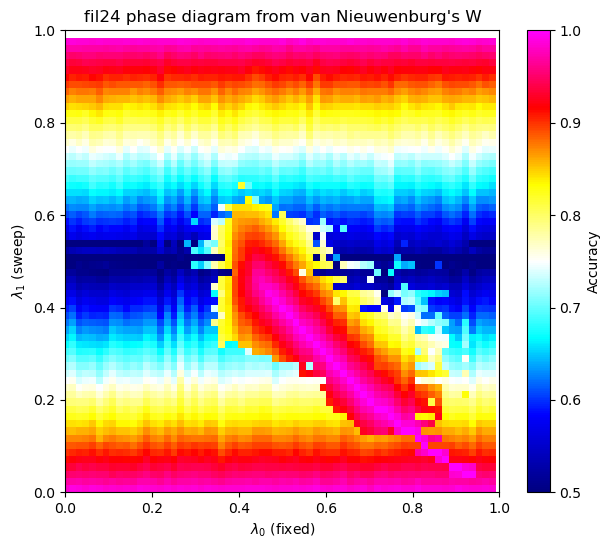

In [124]:
fig, ax = plt.subplots(figsize=(7, 6))
sweep_lambda_index = pipeline.config["sweep_lambda_index"]
fixed_lambda_index = 1 - sweep_lambda_index
do_transpose = (sweep_lambda_index == 0)

x = pipeline.dataset_train["lambda_fixed_unique"]
y = pipeline.dataset_train["lambda_sweep_thresholds"]
z = w["accuracy"].T
if do_transpose:
    x, y, z = y, x, z.T
cp = ax.pcolormesh(x, y, z, cmap=classifim.bench.plot_tools.spiral_background2_cmap, vmin=0.5, vmax=1.0, shading="nearest")

# Add a color bar
cbar = plt.colorbar(cp, ax=ax)
lambda_fixed_latex = "\\lambda_{" + f"{fixed_lambda_index:d}" + "}"
lambda_sweep_latex = "\\lambda_{" + f"{sweep_lambda_index:d}" + "}"
cbar.set_label("Accuracy")

# Set plot labels and title as needed
x_label = f"${lambda_fixed_latex}$ (fixed)"
y_label = "$\\lambda_{" + f"{sweep_lambda_index:d}" + "}$ (sweep)"
if do_transpose:
    x_label, y_label = y_label, x_label
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
dataset_name = os.path.basename(pipeline.config["data_dir"])
ax.set_title(f"{dataset_name} phase diagram from van Nieuwenburg's W")

# Other possible customizations
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Saving the figure if needed
filename = f"{dataset_name}_w_phase_sweep_{sweep_lambda_index}.png"
plt.savefig(filename, dpi=300)
print(f"Saved to {os.path.realpath(filename)}")

# Show the plot
plt.show()

Saved to /home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/bitstring-chifc/supplementary_materials/code/examples/FIL24_w_phase_sweep_0.png


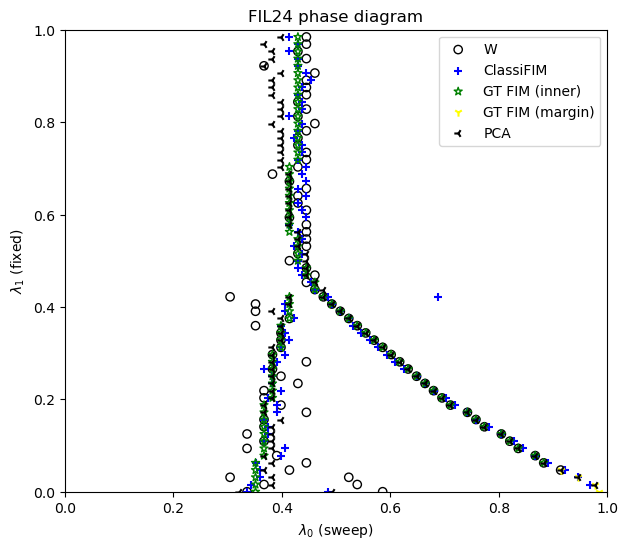

In [98]:
fig, ax = plt.subplots(figsize=(7, 6))
sweep_lambda_index = pipeline.config["sweep_lambda_index"]
fixed_lambda_index = 1 - sweep_lambda_index
do_transpose = (sweep_lambda_index == 1)

def peak_scatter(ax, peaks, subset=None, **kwargs):
    x = peaks["lambda_sweep"]
    y = peaks["lambda_fixed"]
    if do_transpose:
        x, y = y, x
    if subset is not None:
        x = x[subset]
        y = y[subset]
    ax.scatter(x, y, **kwargs)

# Assuming data["x"], data["y"], and data["z"] are already numpy arrays of the same shape
x = pipeline.dataset_train["lambda_sweep_thresholds"]
y = pipeline.dataset_train["lambda_fixed_unique"]
z = w_smoothing(x, w["accuracy"], axis=1, extra_padding=0)
if do_transpose:
    x, y, z = y, x, z.T

# Plotting the data
# cp = ax.pcolormesh(x, y, z, cmap=classifim.bench.plot_tools.spiral_background2_cmap, vmin=0.5, vmax=1.0, shading="nearest")
# cbar = plt.colorbar(cp, ax=ax)
# cbar.set_label("Accuracy")

peak_scatter(
    ax, w_smooth_peaks, marker='o', edgecolors='black', facecolors='none',
    label='W')
peak_scatter(
    ax, ml_smooth_peaks, marker='+', facecolors='blue', label="ClassiFIM")
peak_scatter(
    ax, gs_peaks, subset=gs_peaks["is_inner"], marker='*', edgecolors='green', facecolors='none',
    label="GT FIM (inner)")
peak_scatter(
    ax, gs_peaks, subset=~gs_peaks["is_inner"], marker='1', facecolors='yellow',
    label="GT FIM (margin)")
peak_scatter(
    ax, pca_peaks, marker='3', facecolors='black',
    label="PCA")

lambda_fixed_latex = "\\lambda_{" + f"{fixed_lambda_index:d}" + "}"
lambda_sweep_latex = "\\lambda_{" + f"{sweep_lambda_index:d}" + "}"

# Set plot labels and title as needed
x_label = "$\\lambda_{" + f"{sweep_lambda_index:d}" + "}$ (sweep)"
y_label = f"${lambda_fixed_latex}$ (fixed)"
if do_transpose:
    x_label, y_label = y_label, x_label
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(f"{dataset_name} phase diagram")

# Other possible customizations
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()

# Saving the figure if needed
filename = f"{dataset_name}_w_phase_sweep_{sweep_lambda_index}.png"
plt.savefig(filename, dpi=300)
print(f"Saved to {os.path.realpath(filename)}")

# Show the plot
plt.show()

### Huang's PCA

In [158]:
dataset_name = "Hubbard12"
data_dir = os.path.join(DATA_DIR0, dataset_name.lower())
shadow_jobs = {
    suffix: classifim.huang_pca.ComputeKShadowMatrixPipeline(
        data_dir=data_dir,
        suffix=suffix,
        nbits=24,
        scalar_keys=["seed"],
        load_dataset=True)
    for suffix in range(42, 52)}

In [160]:
%%time
wrapper(42)

42:2024-02-01 20:21:24.566820: computed
42:2024-02-01 20:21:32.327303: saved
42:2024-02-01 20:21:41.857683: done
CPU times: user 17min 11s, sys: 446 ms, total: 17min 11s
Wall time: 17min 4s


In [155]:
def wrapper(key):
    shadow_jobs[key].load_dataset()
    shadow_jobs[key].group_zs()
    shadow_jobs[key].compute_k_shadow()
    print(f"{key}:{datetime.datetime.now()}: computed")
    shadow_jobs[key].save_k_shadow()
    shadow_jobs[key].load_k_shadow()
    print(f"{key}:{datetime.datetime.now()}: saved")
    shadow_jobs[key].compute_pca()
    shadow_jobs[key].save_k_shadow()
    print(f"{key}:{datetime.datetime.now()}: done")
print(f"{datetime.datetime.now()}: starting...")
with concurrent.futures.ThreadPoolExecutor() as executor:
    shadow_wrapper_res = {key: executor.submit(wrapper, key) for key in shadow_jobs.keys()}

2024-02-01 19:18:52.746381: starting...
43:2024-02-01 19:44:51.164513: computed
49:2024-02-01 19:44:58.045383: computed
43:2024-02-01 19:44:58.490607: saved
44:2024-02-01 19:45:00.865836: computed
42:2024-02-01 19:45:01.495908: computed
50:2024-02-01 19:45:05.713029: computed
49:2024-02-01 19:45:07.728875: saved
44:2024-02-01 19:45:10.367779: saved
47:2024-02-01 19:45:10.384808: computed
43:2024-02-01 19:45:12.549278: done
42:2024-02-01 19:45:13.162311: saved
45:2024-02-01 19:45:15.717740: computed
50:2024-02-01 19:45:18.862251: saved
47:2024-02-01 19:45:22.941370: saved
48:2024-02-01 19:45:23.194391: computed
49:2024-02-01 19:45:25.083674: done
44:2024-02-01 19:45:25.850735: done
42:2024-02-01 19:45:26.948281: done
45:2024-02-01 19:45:27.189137: saved
51:2024-02-01 19:45:30.278167: computed
46:2024-02-01 19:45:31.676771: computed
50:2024-02-01 19:45:32.513990: done
48:2024-02-01 19:45:34.146459: saved
47:2024-02-01 19:45:36.368708: done
51:2024-02-01 19:45:38.656510: saved
45:2024-02-

In [101]:
shadow_jobs[42].pca.shape

(64, 64, 10)

Saved to 'fil24_phase_seed42_pca.png'.


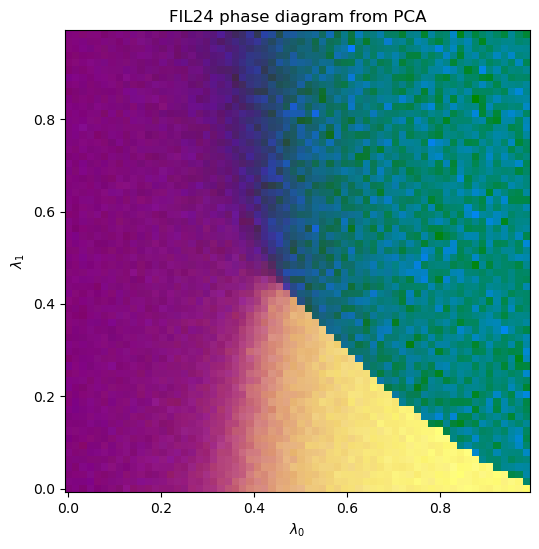

In [108]:
pca3 = shadow_jobs[42].pca[:, :, :3].swapaxes(0, 1)
# pca3 axes: lambda0, lambda1, color
lambda0s = np.arange(64) / 64
lambda1s = np.arange(64) / 64

z = pca3 - np.min(pca3, axis=(0, 1))
z = z / np.max(z, axis=(0, 1))

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolormesh(lambda0s, lambda1s, z.swapaxes(0, 1), shading="nearest")
ax.set_xlabel(r"$\lambda_0$")
ax.set_ylabel(r"$\lambda_1$")
ax.set_title("FIL24 phase diagram from PCA")
filename = f"fil24_phase_seed{dataset_train['seed']}_pca.png"
fig.savefig(filename)
print(f"Saved to '{filename}'.")

In [120]:
if "fims" not in globals() or fims["data_dir"] != data_dir:
    fims = load_fim(data_dir=data_dir)
gs_mg = classifim.bench.peaks.extract_gs_meshgrid(
    fims["gs_fim"], sweep_lambda_index=0)
gs_peaks = classifim.bench.peaks.get_gs_peaks(gs_mg)

In [149]:
all_peak_errors = []
for seed in range(42, 52):
    pca_peaks, pca_s_peaks = [
        classifim.bench.peaks.get_pca_peaks(
            lambda1s,
            lambda0s,
            pca=shadow_jobs[seed].pca,
            num_peaks=gs_peaks["num_peaks"],
            postprocess=postprocess)
        for postprocess in [False, True]]
    peak_errors = classifim.bench.peaks.compute_peak_rmses(
        gs_peaks,
        {"pca_peaks": pca_peaks,
         "pca_s_peaks": pca_s_peaks})
    all_peak_errors.append(peak_errors)

In [150]:
all_peak_errors = pd.DataFrame(all_peak_errors)
all_peak_errors

,num_peaks,num_acc_peaks,num_single_peaks,pca_peaks,pca_s_peaks,pca_peaks_single,pca_s_peaks_single
0,92,88,36,0.017469,0.016986,0.022250,0.019704
1,92,88,36,0.016739,0.017068,0.018779,0.019269
2,92,88,36,0.016656,0.016362,0.020833,0.020130
3,92,88,36,0.016656,0.016063,0.019313,0.018914
4,92,88,36,0.014616,0.015845,0.017662,0.019357
5,92,88,36,0.015536,0.016149,0.018779,0.019357
6,92,88,36,0.016822,0.017229,0.018779,0.019704
7,92,88,36,0.017149,0.016447,0.019313,0.018914
8,92,88,36,0.015714,0.015714,0.018229,0.018276
9,92,88,36,0.017549,0.016615,0.019833,0.019704


In [151]:
for key in [f"pca{s1}_peaks{s2}" for s1 in ["", "_s"] for s2 in ["_single", ""]]:
    values = np.array(all_peak_errors[key])
    print(f"{key:>18s}: {np.mean(values):.4f}±{np.std(values):.4f}")

  pca_peaks_single: 0.0194±0.0013
         pca_peaks: 0.0165±0.0009
pca_s_peaks_single: 0.0193±0.0005
       pca_s_peaks: 0.0164±0.0005


## Benchmarking

### Load FIM

* Requires:
    - internet access to `fiktor/FIM-Estimation` for ground truth FIM
    - estimated FIM (`fim/{ml_model_name}*.npz`)
* Loads FIM into global variables `gt_fims`, `gt_fim_mgrids`, `ML_NAME`, `ml_fims`, `ml_fim_mgrids`.

In [3]:
ML_NAME = "9_reshuffle"
gt_fims = {}
gt_fim_mgrids = {}
ml_fims = {}
ml_fim_mgrids = {}
for sm_name in SM_NAMES:
    gt_fims[sm_name], gt_fim_mgrids[sm_name] = (
        classifim.datasets.load_gt_fim(sm_name=sm_name))
    data_dir = DATA_DIRS[sm_name]
    fim_dir = os.path.join(data_dir, "fim")
    cur_ml_fims, cur_ml_fim_mgrids = classifim.bench.fidelity.read_ml_fims(
        fim_dir, rf'^{ML_NAME}_\d+$',
        ignore_prefix=f'{ML_NAME}_', key_dtype=int)
    ml_fims.update({(sm_name, k): v for k, v in cur_ml_fims.items()})
    ml_fim_mgrids.update({(sm_name, k): v for k, v in cur_ml_fim_mgrids.items()})
print(f"Loaded gt_fims for keys {list(gt_fims.keys())}")
print(f"Loaded ml_fims for keys {list(ml_fims.keys())}")

Generating test split:   0%|          | 0/16002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16002 [00:00<?, ? examples/s]

Loaded gt_fims for keys ['hubbard_12', 'fil_24']
Loaded ml_fims for keys [('hubbard_12', 42), ('hubbard_12', 44), ('hubbard_12', 46), ('hubbard_12', 48), ('hubbard_12', 50), ('hubbard_12', 43), ('hubbard_12', 45), ('hubbard_12', 47), ('hubbard_12', 49), ('hubbard_12', 51), ('fil_24', 42), ('fil_24', 44), ('fil_24', 46), ('fil_24', 48), ('fil_24', 50), ('fil_24', 43), ('fil_24', 45), ('fil_24', 47), ('fil_24', 49), ('fil_24', 51), ('fil_24', 41)]


### 1D "phase" diagrams

* Requires:
    - Run "Load FIM" section above
* Produces 1D plots of ground truth and predicted fidelity susceptibility.

In [204]:
df = [v for k, v in ml_fims.items() if k[0] == sm_name][0]
df[df["lambda1"] == 20 / 64]

,lambda0,lambda1,fim_00,fim_01,fim_11
20,0.000000,0.3125,16.176872,-0.007703,0.020221
84,0.015625,0.3125,15.010894,0.003047,0.021935
148,0.031250,0.3125,13.661767,-0.006876,0.034705
212,0.046875,0.3125,15.551083,-0.022911,0.035758
276,0.062500,0.3125,15.525382,0.118641,0.037593
...,...,...,...,...,...
3796,0.921875,0.3125,9.801291,0.356840,0.014434
3860,0.937500,0.3125,9.933497,0.408192,0.017707
3924,0.953125,0.3125,0.021228,0.001692,0.000135
3988,0.968750,0.3125,4.485326,0.231763,0.012296


Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/figs/fim_9_reshuffle_lambda1_20b-6_thin.png'
Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/figs/fim_9_reshuffle_lambda1_20b-6_thin.png'


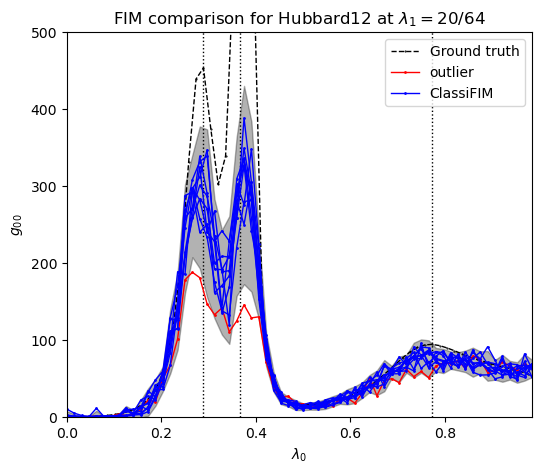

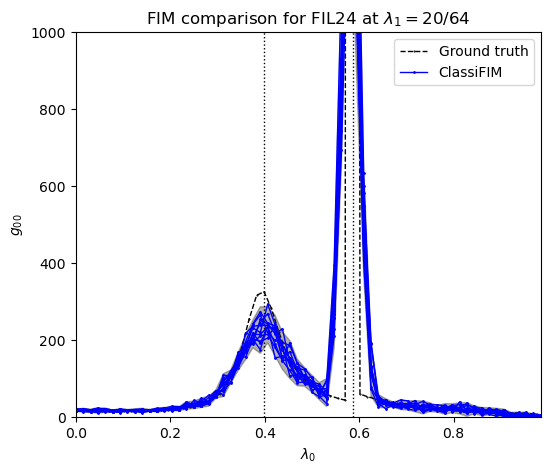

In [216]:
importlib.reload(classifim.bench.plot_tools)
for i, sm_name in enumerate(SM_NAMES):
    fig, ax = plt.subplots(figsize=(6, 5))
    fig_dir = classifim.utils.maybe_create_subdir(DATA_DIRS[sm_name], "figs")
    file_name = os.path.join(fig_dir, f"fim_{ML_NAME}_" + "lambda{fixed_lambda_index}_{fixed_lambda_int_val}b-6_thin.png")
    fixed_lambda = (1, 20)
    cur_ml_fims = sorted([(k, v) for k, v in ml_fims.items() if k[0] == sm_name])
    cur_ml_fims = [v for k, v in cur_ml_fims]
    classifim.bench.plot_tools.plot_fim_df_1d(
        gt_fims[sm_name],
        cur_ml_fims,
        fixed_lambda=fixed_lambda,
        ymax=[500, 1000][i],
        sm_name=SM_NAMES_PRINT[sm_name],
        file_name=file_name,
        ax=ax,
        savefig_kwargs={"dpi": 300},
        verbose=True, # Change to True to print the file name
        fim_vlines=True,
        ml_kwargs=(None if sm_name == "fil_24" else (
            [
                {"color": "red", "label": "outlier"},
                {"label": "ClassiFIM"}]
            + [{}] * (len(cur_ml_fims) - 2)))
    );

### 2D "phase" diagrams

* Requires:
    - Run "Load FIM" section above
* Produces 2D plots of ground truth and predicted fidelity susceptibility.

Saved to '/Volumes/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/figs/hubbard_12_phase_42.png'.
Saved to '/Volumes/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/figs/fil_24_phase_42.png'.


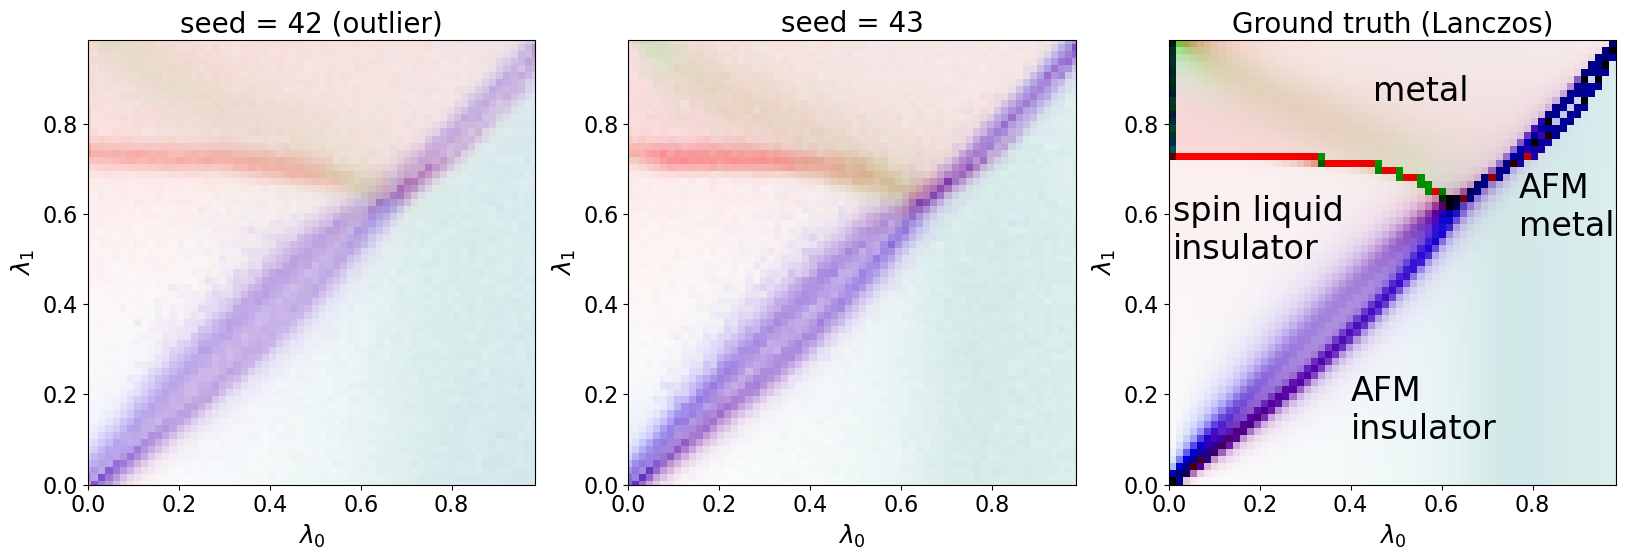

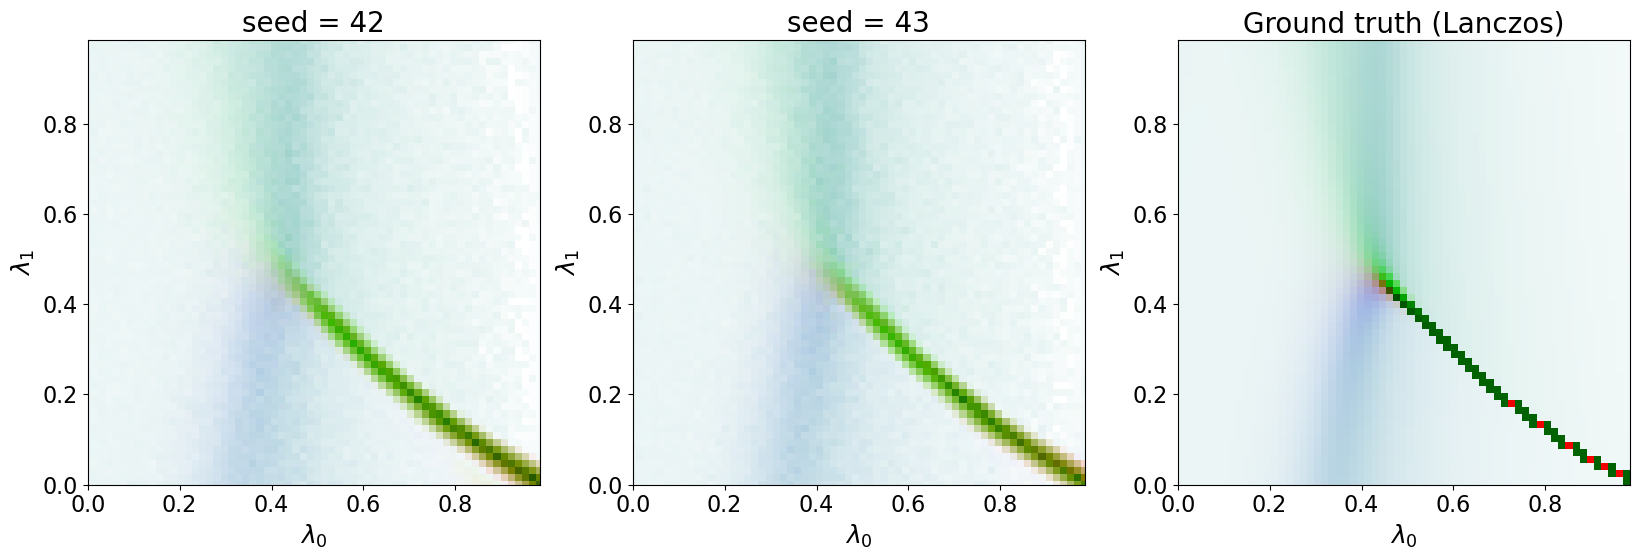

In [17]:
import importlib
importlib.reload(classifim.bench.plot_tools)
for sm_name in SM_NAMES:
    fig_dir = classifim.utils.maybe_create_subdir(DATA_DIRS[sm_name], "figs")
    ml_fim_seed0 = 42
    ml_fim_seed1 = 43
    fig, axs = plt.subplots(ncols=3, figsize=(3 * 5.5, 5.7))
    (ax0, ax1, ax2) = axs
    
    title_fontsize=20
    
    zz_max = 54
    classifim.bench.plot_tools.plot_fim_mgrid(ax0, ml_fim_mgrids[sm_name, ml_fim_seed0], zz_max=zz_max)
    ax0.set_title(
        f"seed = {ml_fim_seed0}" + (" (outlier)" if sm_name == "hubbard_12" else ""),
        fontsize=title_fontsize)
    
    classifim.bench.plot_tools.plot_fim_mgrid(ax1, ml_fim_mgrids[sm_name, ml_fim_seed1], zz_max=zz_max)
    ax1.set_title(f"seed = {ml_fim_seed1}", fontsize=title_fontsize)
    
    classifim.bench.plot_tools.plot_fim_mgrid(ax2, gt_fim_mgrids[sm_name], zz_max=zz_max)
    ax2.set_title("Ground truth (Lanczos)", fontsize=title_fontsize)
    if sm_name == "hubbard_12":
        ax2.text(0.01, 0.5, "spin liquid\ninsulator", fontsize=24)
        ax2.text(0.45, 0.85, "metal", fontsize=24)
        ax2.text(0.4, 0.1, "AFM\ninsulator", fontsize=24)
        ax2.text(0.77, 0.55, "AFM\nmetal", fontsize=24)
    
    plt.tight_layout()
    
    file_name = os.path.join(fig_dir, f"{sm_name}_phase_{ml_fim_seed0}.png")
    fig.savefig(file_name, bbox_inches='tight', dpi=600)
    print(f"Saved to '{file_name}'.")

### 1x7

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/hubbard_12/figs/hubbard_12_phase_1x7_paper.png'.


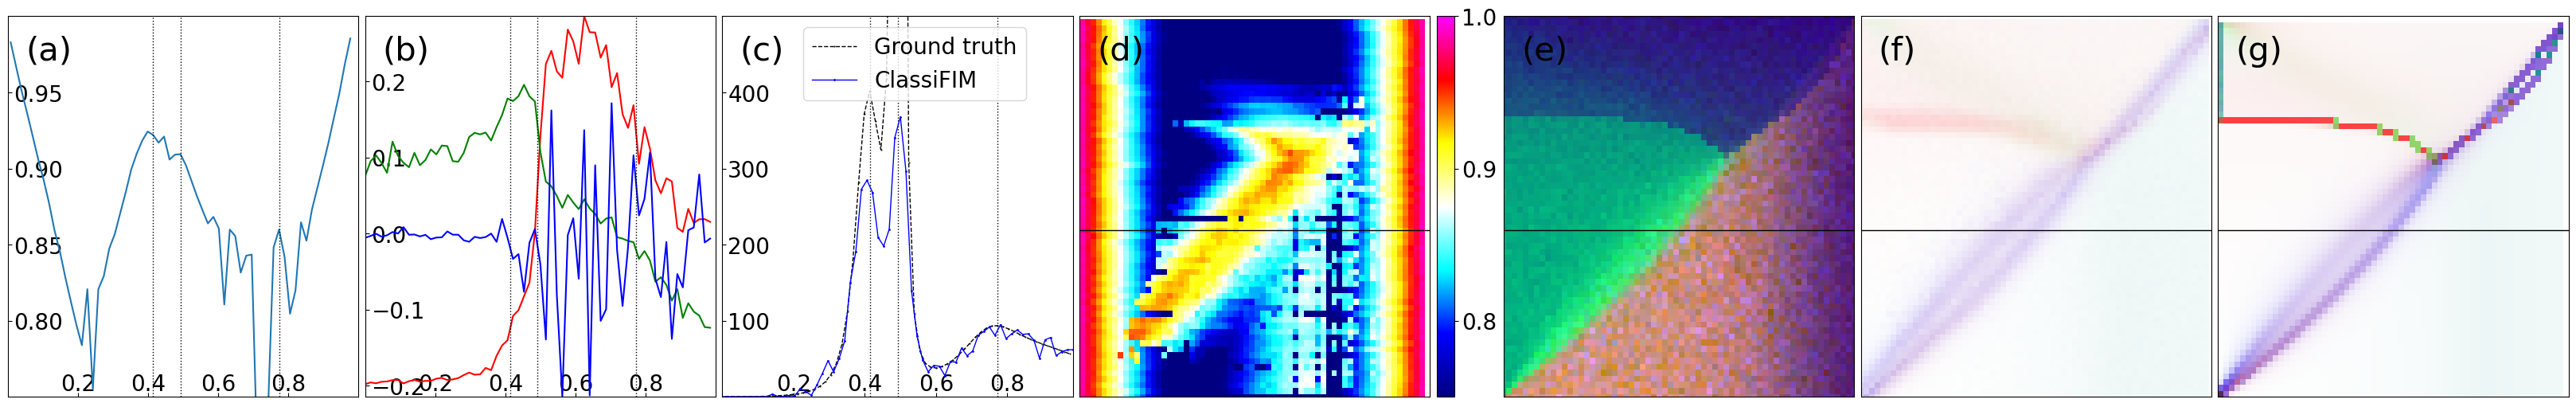

In [198]:
sm_name = "hubbard_12" # "fil_24"
seed = 43
with np.load(os.path.join(DATA_DIRS[sm_name], "models", f"w_{seed}_0.w.npz")) as f:
    w_npz = dict(f)
pca_filename = f"pcaz_k_shadow_{seed:02d}.npz"
with np.load(os.path.join(DATA_DIRS[sm_name], "models", f"pcaz_k_shadow_{seed:02d}.npz")) as f:
    pca = f["pca"].swapaxes(0, 1)

importlib.reload(classifim.bench.plot_tools)
png_scale = 1.0
fig = plt.figure(figsize=(32.25 * png_scale, 5.0 * png_scale), layout='constrained') # TODO:5:check what constrained_layout does.
gs = matplotlib.gridspec.GridSpec(
    1, 8, width_ratios=[1, 1, 1, 1, 0.05, 1, 1, 1], figure=fig)
axs_1d = [fig.add_subplot(gs[0, i]) for i in [0, 1, 2]]
axs_2d = [fig.add_subplot(gs[0, i]) for i in [3, 5, 6, 7]]
cbar_ax0_2d, = cbar_axs = [fig.add_subplot(gs[0, i]) for i in [4]]

lambda1i = 18 if sm_name == "fil_24" else 28
lambda1 = PARAMETER_GRID_EXPANDED[1][lambda1i]

# (a)
classifim.bench.plot_tools.plot_w1d(axs_1d[0], w_npz, lambda_v=lambda1)
axs_1d[0].set_yticks(np.linspace(0.8, 0.95, 4))

# (b)
for i in range(3):
    axs_1d[1].plot(PARAMETER_GRID_EXPANDED[0], pca[:, lambda1i, i], color=['red', 'green', 'blue'][i])
axs_1d[1].set_xlim((0, 1))
axs_1d[1].set_ylim((np.min(pca[:, lambda1i, :3]), np.max(pca[:, lambda1i, :3])))
axs_1d[1].set_yticks(np.linspace(-0.5, 1.5, 5) if sm_name == "fil_24" else np.linspace(-0.2, 0.2, 5))

# (c)
ymax = 500
plot_fim_df_res = classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[sm_name],
    [ml_fims[sm_name, seed]],
    fixed_lambda=(1, lambda1i),
    resolution=63,
    ymax=ymax,
    sm_name=sm_name,
    fim_vlines=True,
    ax=axs_1d[2])
axs_1d[2].set_title(None)
axs_1d[2].set_xlabel(None)
axs_1d[2].set_ylabel(None)
axs_1d[2].legend(loc='upper left', bbox_to_anchor=(0.2, 1.0), fontsize=20)
axs_1d[2].set_yticks(np.arange(1, 5) * 1e2)

for ax in axs_1d:
    ax.tick_params(axis='x', direction='in', pad=-22, labelsize=20)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    ax.tick_params(axis='y', direction='in', pad=-5, labelsize=20)
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')


for ax in axs_1d[:2]:
    for vline in plot_fim_df_res["fim_vlines"]:
        ax.axvline(vline, color='black', linestyle=':', linewidth=1.0)

classifim.bench.plot_tools.plot_w2d(axs_2d[0], w_npz, colorbar=True, cbar_ax=cbar_ax0_2d)
cbar_ax0_2d.tick_params(axis='y', labelsize=20)
cbar_ax0_2d.set_yticks([0.8, 0.9, 1.0])
classifim.bench.plot_tools.plot_pca(axs_2d[1], pca)
# ax1.set_title("W")
zz_max = 140
classifim.bench.plot_tools.plot_fim_mgrid(
    axs_2d[2], ml_fim_mgrids[sm_name, seed], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(
    axs_2d[3], gt_fim_mgrids[sm_name], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax3.set_title("Ground truth, from DMRG")
for ax in axs_2d:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)
    ax.axhline(lambda1, color='black', linewidth=1)

for i, ax in enumerate(axs_1d + axs_2d):
    panel_label = f'({chr(97 + i)})'  # 97 is the ASCII code for 'a'
    # Position the text at the top left corner of the panel
    # Adjust x and y values as needed to fit your specific figure layout
    ax.text(0.05, 0.95, panel_label, transform=ax.transAxes, fontsize=30,
            verticalalignment='top', horizontalalignment='left',
            color='black')

filename = os.path.join(DATA_DIRS[sm_name], "figs", f"{sm_name}_phase_1x7_paper.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

### Test error

Hubbard12

In [30]:
# This was just copied the cell outputs manually
test_losses = np.array([0.257957, 0.248262, 0.247800, 0.247734, 0.248502, 0.249487, 0.249052, 0.247307, 0.249522, 0.250295])
print(classifim.bench.metric.normal_summary(test_losses))

0.2496 \pm 0.0029


FIL24

In [31]:
# This was just copied the cell outputs manually
test_losses = np.array([0.241673, 0.241832, 0.243290, 0.241828, 0.242699, 0.242008, 0.240938, 0.242542, 0.241491, 0.243552])
print(classifim.bench.metric.normal_summary(test_losses))

0.2422 \pm 0.0008


### Compute dist metrics

* Requires:
    - Run "Load ChiFc" section above
* Produces: `metrics/dist_res.npz` with distSE values, distMSE & distRE metrics

In [33]:
METRICS_DIRS = {
    sm_name: classifim.utils.maybe_create_subdir(v, "metrics")
    for sm_name, v in DATA_DIRS.items()}

In [11]:
%%time
sm_name = "hubbard_12"
res = {}
def wrapper(ml_fim_seed):
    prng = classifim.utils.DeterministicPrng(ml_fim_seed)
    cur_res = classifim.bench.metric.compute_distance_errors(
        grid=PARAMETER_GRID,
        ml_fim_mgrids[sm_name, ml_fim_seed],
        gt_fim_mgrids[sm_name],
        num_pairs=8386560,
        seed=prng.get_seed("compute_distance_errors"),
        use_cpp=True)
    res[ml_fim_seed] = cur_res
    return ml_fim_seed
with concurrent.futures.ThreadPoolExecutor() as executor:
    r = list(executor.map(wrapper, range(42, 52)))

CPU times: user 2h 12min 53s, sys: 1min 51s, total: 2h 14min 45s
Wall time: 1h 38min 38s


In [12]:
dist_res = {}
for key in next(iter(res.values())).keys():
    value = np.array([r[key] for r in res.values()])
    dist_res[key] = value
dist_res["ml_fim_seed"] = np.array(list(res.keys()))
dist_res_filename = os.path.join(METRICS_DIRS[sm_name], "dist_res.npz")
np.savez_compressed(dist_res_filename, **dist_res)

In [143]:
with np.load(dist_res_filename) as f:
    npz = dict(f)

In [146]:
myu.dir_dict(npz)

num_pairs: int64 (10,)
lambda_pairs: float64 (10, 2, 8386560, 2)
distances: float64 (10, 2, 8386560)
distMSE: float64 (10,)
distRE: float64 (10,)
distMSE_const: float64 (10,)
distRE_const: float64 (10,)
distRE_perfect: float64 (10,)
distMSE_perfect_scale: float64 (10,)
scale: float64 (10,)
ml_chifc_seed: int64 (10,)


In [147]:
npz["ml_fim_seed"] = npz["ml_chifc_seed"]
del npz["ml_chifc_seed"]
np.savez_compressed(dist_res_filename, **npz)

### Print dist metrics

* Requires `metrics/dist_res.npz`
* Prints `distMSE` and `distRE` metrics

In [151]:
METRICS_DIRS = {
    sm_name: os.path.join(v, "metrics")
    for sm_name, v in DATA_DIRS.items()}
for i, sm_name in enumerate(SM_NAMES):
    if i:
        print()
    print(f"{SM_NAMES_PRINT[sm_name]}:")
    dist_res_filename = os.path.join(METRICS_DIRS[sm_name], "dist_res.npz")
    with np.load(dist_res_filename) as f:
        df = pd.DataFrame({
            key: value
            for key in f.keys()
            if key not in ["lambda_pairs", "distances"]
                and len((value := f[key]).shape) == 1
        })
    df.set_index("ml_fim_seed", inplace=True)

    display(df)

    for column_name, values in df.items():
        digits = 4
        if 'distRE' in column_name:
            digits = 2
            values = values * 100
            column_name = column_name + " (%)"
        elif column_name.startswith("num_"):
            digits = 0
        print(
            f"{column_name}: "
            f"${classifim.bench.metric.normal_summary(values, digits=digits)}$")

Hubbard12:


,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,scale
ml_fim_seed,,,,,,,,
43,8386560,3.875948,0.076836,6.203232,0.236423,0.0,1.511021,1.374217
50,8386560,3.952172,0.074877,6.203232,0.236423,0.0,1.464949,1.387085
51,8386560,3.650210,0.075025,6.203232,0.236423,0.0,1.420605,1.358757
45,8386560,3.707476,0.073107,6.203232,0.236423,0.0,1.439422,1.363101
47,8386560,3.774253,0.075812,6.203232,0.236423,0.0,1.495291,1.364725
49,8386560,3.941709,0.075317,6.203232,0.236423,0.0,1.457385,1.386708
44,8386560,3.841102,0.075957,6.203232,0.236423,0.0,1.500511,1.371485
46,8386560,3.643368,0.074629,6.203232,0.236423,0.0,1.480401,1.351901
48,8386560,3.644686,0.073723,6.203232,0.236423,0.0,1.409432,1.359289


num_pairs: $8386560 \pm 0$
distMSE: $3.9814 \pm 0.6110$
distRE (%): $7.69 \pm 0.56$
distMSE_const: $6.2032 \pm 0.0000$
distRE_const (%): $23.64 \pm 0.00$
distRE_perfect (%): $0.00 \pm 0.00$
distMSE_perfect_scale: $1.5029 \pm 0.1200$
scale: $1.3863 \pm 0.0543$

FIL24:


,num_pairs,distMSE,distRE,distMSE_const,distRE_const,distRE_perfect,distMSE_perfect_scale,scale
ml_fim_seed,,,,,,,,
43,8386560,0.457575,0.042942,4.207848,0.255958,8.815035e-13,0.279303,1.109370
48,8386560,0.469291,0.043967,4.207848,0.255958,8.815035e-13,0.289217,1.110015
47,8386560,0.424193,0.041681,4.207848,0.255958,8.815035e-13,0.268281,1.101527
45,8386560,0.458561,0.043924,4.207848,0.255958,8.815035e-13,0.272671,1.111918
51,8386560,0.478792,0.043647,4.207848,0.255958,8.815035e-13,0.270840,1.119136
46,8386560,0.549583,0.047364,4.207848,0.255958,8.815035e-13,0.306244,1.130285
50,8386560,0.487333,0.044026,4.207848,0.255958,8.815035e-13,0.292032,1.115106
49,8386560,0.435056,0.042871,4.207848,0.255958,8.815035e-13,0.268489,1.105299
42,8386560,0.460136,0.043637,4.207848,0.255958,8.815035e-13,0.277793,1.110744


num_pairs: $8386560 \pm 0$
distMSE: $0.4684 \pm 0.0323$
distRE (%): $4.39 \pm 0.14$
distMSE_const: $4.2078 \pm 0.0000$
distRE_const (%): $25.60 \pm 0.00$
distRE_perfect (%): $0.00 \pm 0.00$
distMSE_perfect_scale: $0.2809 \pm 0.0116$
scale: $1.1123 \pm 0.0075$


### Peaks

#### GT

In [169]:
importlib.reload(classifim.bench.peaks)
gt_peaks = {}
for sm_name, sweep_lambda_index in itertools.product(SM_NAMES, [0, 1]):
    gt_mg = classifim.bench.peaks.extract_gt_meshgrid(
        gt_fims[sm_name], sweep_lambda_index=sweep_lambda_index)
    gt_peaks[sm_name, sweep_lambda_index] = classifim.bench.peaks.get_gt_peaks(
        gt_mg=gt_mg, min_prominence=1.0)

In [170]:
sm_name = "fil_24"
seed = 51
sweep_lambda_index = 1
cur_gt_peaks = gt_peaks[sm_name, sweep_lambda_index]
cur_gt_fim = gt_fims[sm_name]

#### PCA

In [173]:
models_dir = os.path.join(DATA_DIRS[sm_name], "models")
seed = 51
pca_filename = f"pcaz_k_shadow_{seed}.npz"
with np.load(os.path.join(models_dir, pca_filename)) as f:
    pca = f["pca"].swapaxes(0, 1)
pca_peaks = classifim.bench.peaks.get_pca_peaks(
    *[np.linspace(*g) for g in PARAMETER_GRID],
    pca=pca[:, :, :2],
    num_peaks=cur_gt_peaks["num_peaks"],
    postprocess=True,
    sweep_lambda_index=sweep_lambda_index)

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/figs/fil_24_pca_peaks_1.png.


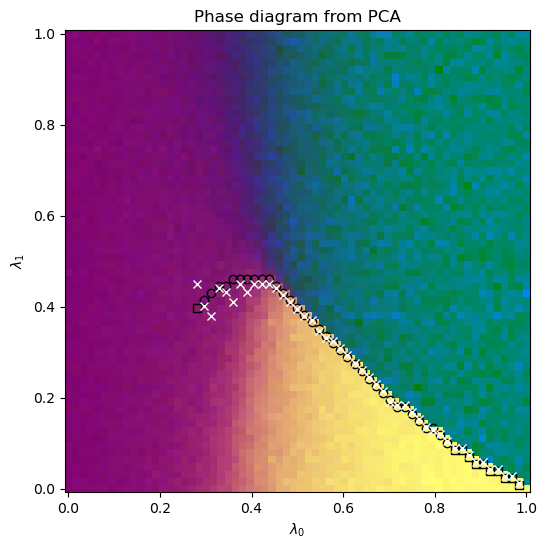

In [110]:
importlib.reload(classifim.bench.plot_tools)
fig, ax = plt.subplots(figsize=(6, 6))
classifim.bench.plot_tools.plot_pca(ax, pca)
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks)
xs, ys = pca_peaks["lambda_sweep"], pca_peaks["lambda_fixed"]
if sweep_lambda_index:
    xs, ys = ys, xs
ax.plot(xs, ys, 'x', mfc='none', mec='white')
file_name = os.path.join(
    DATA_DIRS[sm_name],
    "figs",
    f"{sm_name}_pca_peaks_{sweep_lambda_index}.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

#### ClassiFIM

In [114]:
importlib.reload(classifim.bench.peaks)
seed = 51
ml_mg = classifim.bench.peaks.extract_ml_meshgrid(
    ml_fim_mgrids[sm_name, seed], sweep_lambda_index)
classifim_peaks = classifim.bench.peaks.get_classifim_peaks(
    ml_mg,
    num_peaks=cur_gt_peaks["num_peaks"],
    lambda_fixed_expected=cur_gt_peaks["lambda_fixed"],
    lambda_fixed_tolerance=2**(-23), # np.float32 ulp
    postprocess=True)

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/figs/fil_24_classifim_peaks_1.png.


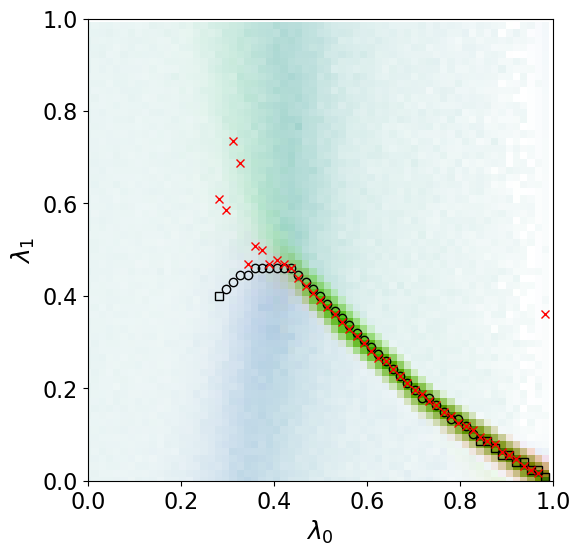

In [115]:
fig, ax = plt.subplots(figsize=(6, 6))
zz_max = 54
classifim.bench.plot_tools.plot_fim_mgrid(
    ax, ml_fim_mgrids[sm_name, seed], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks)
xs, ys = classifim_peaks["lambda_sweep"], classifim_peaks["lambda_fixed"]
if sweep_lambda_index:
    xs, ys = ys, xs
ax.plot(xs, ys, 'x', mfc='none', mec='red')
file_name = os.path.join(
    DATA_DIRS[sm_name],
    "figs",
    f"{sm_name}_classifim_peaks_{sweep_lambda_index}.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/figs/fil_24_classifim_peaks_1d.png.


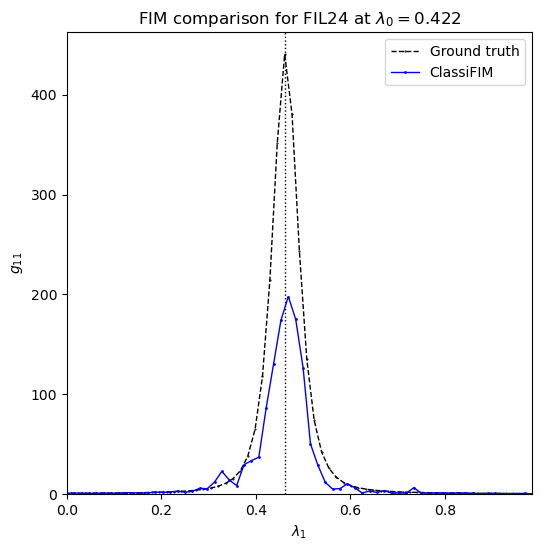

In [118]:
importlib.reload(classifim.bench.plot_tools)
fig, ax = plt.subplots(figsize=(6, 6))
ymax = {"hubbard_12": 800}.get(sm_name)
plot_fim_df_res = classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[sm_name],
    [ml_fims[sm_name, seed]],
    fixed_lambda=(1 - sweep_lambda_index, 27),
    resolution=63,
    ymax=ymax,
    sm_name=SM_NAMES_PRINT[sm_name],
    fim_vlines=True,
    ax=ax)
file_name = os.path.join(
    DATA_DIRS[sm_name], "figs", f"{sm_name}_classifim_peaks_1d.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

#### W

In [105]:
importlib.reload(classifim.bench.peaks)
w_model_name = f"w_{seed:02d}"
w_filename = f"{w_model_name}_{sweep_lambda_index}.w.npz"
with np.load(os.path.join(DATA_DIRS[sm_name], "models", w_filename)) as f:
    w_npz = dict(f)
w_peaks = classifim.bench.peaks.get_w_peaks(
    lambda_fixed=w_npz["lambda_fixed"],
    lambda_sweep=w_npz["lambda_sweep_thresholds"],
    w_accuracy=w_npz["accuracy"],
    num_peaks=cur_gt_peaks["num_peaks"],
    xrange=[cur_gt_peaks[key] for key in ["xmin", "xmax"]],
    lambda_fixed_expected=cur_gt_peaks["lambda_fixed"],
    postprocess=True)

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/figs/fil_24_w_peaks_1.png.


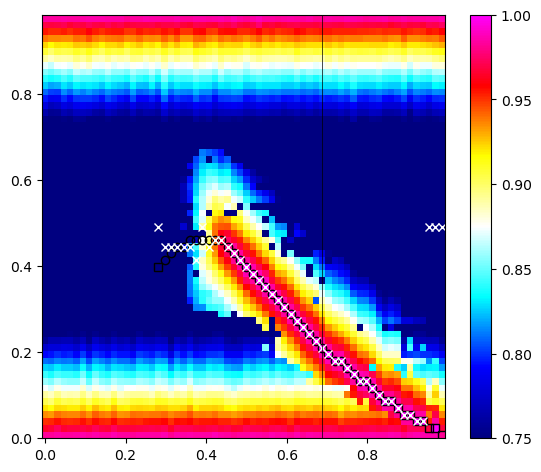

In [106]:
importlib.reload(classifim.bench.plot_tools)
fig, ax = plt.subplots(figsize=(6.5, 5.5))
classifim.bench.plot_tools.plot_w2d(
    ax, w_npz, sweep_axis=sweep_lambda_index, colorbar=True)
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks)
xs, ys = w_peaks["lambda_sweep"], w_peaks["lambda_fixed"]
if sweep_lambda_index:
    xs, ys = ys, xs
ax.plot(
    xs, ys,
    'x', mfc='none', mec='white')
lambda_sweep_i = 43
lambda_sweep = PARAMETER_GRID_EXPANDED[sweep_lambda_index][lambda_sweep_i]
(ax.axvline if sweep_lambda_index else ax.axhline)(
    lambda_sweep, color='black', linewidth=0.5)
file_name = os.path.join(DATA_DIRS[sm_name], "figs", f"{sm_name}_w_peaks_{sweep_lambda_index}.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil_24/figs/fil_24_w_peaks_1d.png.


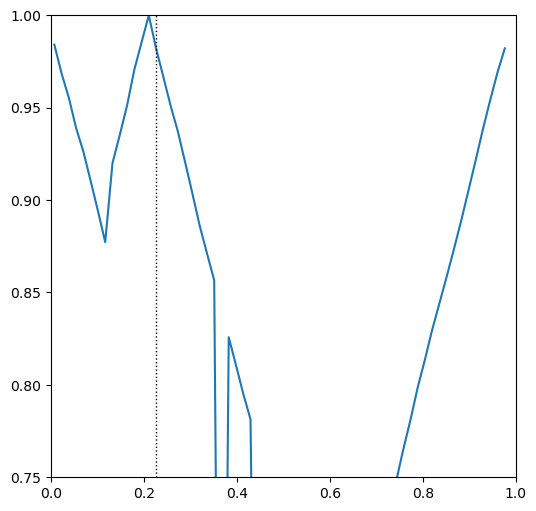

In [119]:
fig, ax = plt.subplots(figsize=(6, 6))
classifim.bench.plot_tools.plot_w1d(ax, w_npz, lambda_v=lambda_sweep)
for vline in cur_gt_peaks['lambda_sweep'][cur_gt_peaks['lambda_fixed_ii'] == lambda_sweep_i]:
    ax.axvline(vline, color='black', linestyle=':', linewidth=1.0)
file_name = os.path.join(DATA_DIRS[sm_name], "figs", f"{sm_name}_w_peaks_1d.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

#### Peak metrics

In [136]:
%%time
importlib.reload(classifim.bench.peaks)
all_peak_errors = []
for (sm_name, sweep_lambda_index), cur_gt_peaks in gt_peaks.items():
    gt_num_peaks, gt_lambda_fixed = [
        cur_gt_peaks[key] for key in ["num_peaks", "lambda_fixed"]]
    cur_gt_fim = gt_fims[sm_name]
    models_dir = os.path.join(DATA_DIRS[sm_name], "models")
    for seed in range(42, 52):
        cur_peaks = {}
        methods = ["classifim"]
        ml_mg = classifim.bench.peaks.extract_ml_meshgrid(
            ml_fim_mgrids[sm_name, seed], sweep_lambda_index)
        ml_peaks, ml_smooth_peaks = [
            classifim.bench.peaks.get_classifim_peaks(
                ml_mg,
                num_peaks=gt_num_peaks,
                lambda_fixed_expected=gt_lambda_fixed,
                lambda_fixed_tolerance=2**(-23), # np.float32 ulp
                postprocess=postprocess)
            for postprocess in [False, True]]
        cur_peaks[f"classifim_peaks"] = ml_peaks
        cur_peaks[f"classifim_smooth_peaks"] = ml_smooth_peaks
    
        methods.append("w")
        w_model_name = f"w_{seed:02d}"
        w_filename = f"{w_model_name}_{sweep_lambda_index}.w.npz"
        with np.load(os.path.join(models_dir, w_filename)) as f:
            w_npz = dict(f)
        cur_peaks["w_peaks"], cur_peaks["w_smooth_peaks"] = [
            classifim.bench.peaks.get_w_peaks(
                lambda_fixed=w_npz["lambda_fixed"],
                lambda_sweep=w_npz["lambda_sweep_thresholds"],
                w_accuracy=w_npz["accuracy"],
                num_peaks=gt_num_peaks,
                lambda_fixed_expected=gt_lambda_fixed,
                postprocess=postprocess,
                xrange=[cur_gt_peaks[key] for key in ["xmin", "xmax"]])
            for postprocess in [False, True]]
        
        methods.append("pca")
        pca_filename = f"pcaz_k_shadow_{seed:02d}.npz"
        with np.load(os.path.join(models_dir, pca_filename)) as f:
            pca = f["pca"].swapaxes(0, 1)
        cur_peaks["pca_peaks"], cur_peaks["pca_smooth_peaks"] = [
            classifim.bench.peaks.get_pca_peaks(
                grid=PARAMETER_GRID, pca=pca[..., :2], num_peaks=gt_num_peaks,
                postprocess=postprocess, sweep_lambda_index=sweep_lambda_index)
            for postprocess in [False, True]]
        peak_errors = classifim.bench.peaks.compute_peak_rmses(cur_gt_peaks, cur_peaks)
        peak_errors["seed"] = seed
        peak_errors["sm_name"] = sm_name
        peak_errors["sweep_lambda_index"] = sweep_lambda_index
        peak_errors["num_peaks"] = np.sum(cur_gt_peaks["is_inner"])
        peak_errors["num_peaks_single"] = np.sum(
            cur_gt_peaks["is_inner"] & cur_gt_peaks["is_single"])
        peak_errors["methods"] = methods
        all_peak_errors.append(peak_errors)

CPU times: user 3min 42s, sys: 11.8 s, total: 3min 54s
Wall time: 39.2 s


In [137]:
importlib.reload(classifim.bench.peaks)
peak_metrics_df_raw = classifim.bench.peaks.peak_errors2d_to_df(
    all_peak_errors, top_keys=["sm_name", "seed", "sweep_lambda_index"])
peak_metrics_df = classifim.bench.peaks.peak_errors2d_agg_sweeps(
    peak_metrics_df_raw, keys=["sm_name", "seed", "method_name"])

In [138]:
peak_metrics_df

,sm_name,seed,method_name,num_rows,num_peaks,num_peaks_single,peaks,smooth_peaks,peaks_single,smooth_peaks_single
0,fil_24,42,classifim,2,123,71,0.026536,0.025786,0.031890,0.031442
1,fil_24,42,pca,2,123,71,0.016490,0.015541,0.016792,0.015563
2,fil_24,42,w,2,123,71,0.074716,0.022586,0.119537,0.024496
3,fil_24,43,classifim,2,123,71,0.017412,0.015465,0.019426,0.017859
4,fil_24,43,pca,2,123,71,0.018369,0.015826,0.020732,0.016888
5,fil_24,43,w,2,123,71,0.075653,0.028124,0.134785,0.031984
6,fil_24,44,classifim,2,123,71,0.020258,0.029686,0.023290,0.037306
7,fil_24,44,pca,2,123,71,0.017709,0.018460,0.018543,0.020602
8,fil_24,44,w,2,123,71,0.078748,0.033041,0.123436,0.037821
9,fil_24,45,classifim,2,123,71,0.026685,0.038215,0.032212,0.049123


In [139]:
for i, (sm_name, df) in enumerate(peak_metrics_df.groupby("sm_name")):
    if i:
        print()
    print(f"{sm_name}:")
    classifim.bench.peaks.paired_t_tests(
        df, metric_name="smooth_peaks", verbose=True);

fil_24:
classifim vs pca: 0.028 > 0.017 (t-stat=4.157, p=0.002)
classifim vs w: 0.028 ≈ 0.026 (t-stat=0.629, p=0.545)
pca vs w: 0.017 < 0.026 (t-stat=-7.197, p=0.000)

hubbard_12:
classifim vs pca: 0.035 ≈ 0.039 (t-stat=-2.064, p=0.069)
classifim vs w: 0.035 < 0.076 (t-stat=-20.695, p=0.000)
pca vs w: 0.039 < 0.076 (t-stat=-74.520, p=0.000)


In [140]:
metric_names = ["peaks", "peaks_single", "smooth_peaks", "smooth_peaks_single"]
dfg = peak_metrics_df.groupby(["sm_name", "method_name"]).agg(
    **{k: (k, "mean") for k in ["num_peaks", "num_peaks_single"]},
    **{
        metric + ("" if fun == "mean" else "." + fun): (metric, fun)
        for metric in metric_names
        for fun in ["mean", "std"]})
dfg

num_peaks  num_peaks_single     peaks  peaks.std  \
sm_name    method_name                                                     
fil_24     classifim        123.0              71.0  0.028483   0.010119   
           pca              123.0              71.0  0.017314   0.001301   
           w                123.0              71.0  0.076629   0.005402   
hubbard_12 classifim        307.0              17.0  0.039792   0.005455   
           pca              307.0              17.0  0.053927   0.000684   
           w                307.0              17.0  0.101044   0.006689   

                        peaks_single  peaks_single.std  smooth_peaks  \
sm_name    method_name                                                 
fil_24     classifim        0.034767          0.013963      0.028031   
           pca              0.018205          0.001974      0.016715   
           w                0.125701          0.008349      0.025924   
hubbard_12 classifim        0.011915          0.001617      0.034517   
           pca              0.127136          0.014563      0.038875   
           w                0.188313          0.007617      0.076303   

                        smooth_peaks.std  smooth_peaks_single  \
sm_name    method_name                                          
fil_24     classifim            0.008451             0.034816   
           pca                  0.001027             0.017770   
           w                    0.004304             0.027993   
hubbard_12 classifim            0.006575             0.013051   
           pca                  0.000745             0.013693   
           w                    0.001619             0.190365   

                        smooth_peaks_single.std  
sm_name    method_name                           
fil_24     classifim                   0.011359  
           pca                         0.001698  
           w                           0.006353  
hubbard_12 classifim                   0.001622  
           pca                         0.000944  
           w                           0.007083

# Scratch